In [1694]:
import logging
import warnings
import pypsa
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import matplotlib.ticker as ticker
import matplotlib.dates as mdates
import matplotlib.patches as mpatches
import geopandas as gpd
import seaborn as sns
warnings.filterwarnings('ignore')
logging.getLogger().setLevel(logging.WARNING)


In [1695]:
red1 = '#891D2D'
red2 = '#BA3B31'
orange = '#F58221'
yellow = '#FCAF19'
brown = '#440A15'
brown2 = '#B45419'
purple1 = '#3B1053'
purple2 = '#76518E'
purple3 = '#B69DC7'
teal1 = '#032838'
teal2 = '#154655'
teal3 = '#527D77'
teal4 = '#8DB5AF'
teal1 = '#294839'
green1 = '#6DA08C'
green2 = '#6E966E'
green3 = '#A3BDA3'
beige1 = '#7A693B'
beige2 = '#A89677'
beige3 = '#D2CDAD'
grey1 = '#E7E7E7'
grey2 = '#D7D7D7'
grey3 = '#C6C6C6'
grey4 = '#939393'
blue1 = '#3EA1C0'

In [1696]:
case = 'Base NZE 30'
case_path = 'base_nze_30_biocp'
code = 'BNZE30_'

PyPSA_OG = True
PyPSA_compare = True
Empire = True
Empire_validering = False
PyPSA_OG_validering = False

In [1697]:
path = 'C:/Users/noraky/Documents/Masteroppgave/pypsa-earth/'
#path_name = 'C:/Users/noraky/Documents/Masteroppgave/pypsa-earth/results/networks/elec_s_all_ec_lcopt_Co2L-1H.nc'
path_name = 'C:/Users/noraky/Documents/Masteroppgave/pypsa-earth/' + case_path + '/' + code
#path_fig = 'C:/Users/noraky/Documents/Masteroppgave/pypsa-earth/figures_' + case_path + '/'
#years = [2024, 2025, 2026, 2027, 2028, 2029, 2030, 2031, 2032, 2033, 2034, 2035, 2036, 2037, 2038, 2039, 2040]
years = [2025, 2026, 2027, 2028, 2029, 2030, 2031, 2032, 2033, 2034, 2035, 2036, 2037, 2038, 2039]
#years = [2029, 2034, 2039]
networks = [pypsa.Network(path_name + str(year) + '.nc') for year in years]
#networks = [pypsa.Network(path_name)]
networks = dict(zip(years, networks))
first_year = years[0]
final_year = years[-1]
first_year_empire = 2025
WACC = 0.05
discountrate = 0.04
horizon = 2039-2025

In [1698]:
save_to_csv = False
all_saved = False

In [1699]:
# Helper functions

def get_power_prod(year):
    network = networks[year]
    carrier_list = network.generators.carrier.unique()
    carrier_list_2 = network.storage_units.carrier.unique()
    carriers = np.concatenate((carrier_list, carrier_list_2), axis=None)
    production_data = {}
    first_date = "2013-01-01"
    second_date = "2013-12-31"
    # for carrier in carriers:
    #     production_data[carrier] = get_snapshot_generation(year, first_date, second_date, carrier).sum() /1e6
 
    production_data["CCGT"] = get_snapshot_generation(year, first_date, second_date, "CCGT").sum() /1e6
    production_data["OCGT"] = get_snapshot_generation(year, first_date, second_date, "OCGT").sum() /1e6
    production_data["oil"] = get_snapshot_generation(year, first_date, second_date, "oil").sum() /1e6
    production_data["geothermal"] = get_snapshot_generation(year, first_date, second_date, "geothermal").sum() /1e6
    production_data["hydro"] = get_snapshot_generation(year, first_date, second_date, "hydro").sum() /1e6
    production_data["onwind"] = get_snapshot_generation(year, first_date, second_date, "onwind").sum() /1e6
    production_data["solar"] = get_snapshot_generation(year, first_date, second_date, "solar").sum() /1e6
    production_data["biomass"] = get_snapshot_generation(year, first_date, second_date, "biomass").sum() /1e6
    production_data["ror"] = get_snapshot_generation(year, first_date, second_date, "ror").sum() /1e6
    production_data["load"] = get_snapshot_generation(year, first_date, second_date, "load").sum() /1e6
 
    df = pd.DataFrame([production_data])
    df['hydro'] += df.pop('ror')
    return df

def get_bus(bus_name, bus_info):
    if bus_name == bus_info['Bus']:
        return bus_info['x'], bus_info['y']

def get_demand(year): 
    network = networks[year]
    el_demand =network.loads_t.p_set
    regional_demand = pd.DataFrame(el_demand.sum()/1000000)
    return regional_demand.sum()

def total_production(year):
    prod = pd.DataFrame(get_power_prod(year))
    prod.drop('load', axis=1, inplace=True)
    return prod.sum().sum()

def get_power_mix(year):
    total_prod = total_production(year)
    prod = get_power_prod(year)
    prod_series = prod.iloc[0].drop('load', errors='ignore')
    fractions = prod_series / total_prod

    df = pd.DataFrame(fractions).transpose()
    df.index = [year]  
    return df

def get_max_output(year):
    network = networks[year]
    return network.generators.groupby(by='carrier')["p_max_pu"].sum()

def custom_autopct(pct):
    return ('%1.1f%%' % pct) if pct > 0 else ''

def get_objective(year):
    network = networks[year]
    return network.objective /1e6

def get_total_cost(year):
    network = networks[year]
    return (network.statistics.capex().sum() + network.statistics.opex().sum())/1e6

def get_emissions(year):
    network = networks[year]
    emissions = network.generators_t.p / network.generators.efficiency * network.generators.carrier.map(network.carriers.co2_emissions)
    return emissions.sum().sum() / 1000000

def get_installed_capacity(year):
    network = networks[year]

    capacities = network.generators.groupby(by='carrier')['p_nom_opt'].sum()

    if 'ror' in capacities:
        capacities['hydro'] = capacities.get('hydro', 0) + capacities.pop('ror')

    if 'hydro' in network.storage_units.carrier.unique():
        hydro_capacity = network.storage_units[network.storage_units.carrier == 'hydro']['p_nom_opt'].sum()
        capacities['hydro'] += hydro_capacity

    capacities.pop('load')
    capacities_df = capacities.to_frame().transpose()
    capacities_df.index = [year]

    return capacities_df

def get_installed_capacity_hydro(year):
    network = networks[year]

    capacities = network.generators.groupby(by='carrier')['p_nom_opt'].sum()

    capacities.pop('load')
    capacities_df = capacities.to_frame().transpose()
    capacities_df.index = [year]

    return capacities_df

def get_installed_capacity_charge(year):
    network = networks[year]
    capacities_discharge = network.links.groupby(by='carrier')['p_nom'].sum()
    capacities_discharge_df = capacities_discharge.to_frame().transpose()
    capacities_discharge_df.index = [year]
    return capacities_discharge_df

def get_installed_capacity_battery(year):
    network = networks[year]
    storage_capacity = network.stores.groupby(by='carrier')['e_nom'].sum()
    storage_capacity_df = storage_capacity.to_frame().transpose()
    storage_capacity_df.index = [year]
    return storage_capacity_df

def get_installed_capacity_lines(year):
    network = networks[year]
    lines_capacity = network.lines.groupby(by='carrier')['s_nom'].sum()
    lines_capacity_df = lines_capacity.to_frame().transpose()
    lines_capacity_df.index = [year]
    return lines_capacity_df

def get_snapshot_generation(year, first_date, second_date, carrier):
    network = networks[year]
    if carrier == 'hydro':
        generation = network.storage_units_t.p_dispatch[first_date:second_date].groupby(network.storage_units.carrier, axis=1).sum()[carrier]
    elif carrier == 'battery' or carrier == 'H2':
        generation = network.stores_t.p.loc[first_date:second_date].groupby(network.stores.carrier, axis=1).sum()[carrier]
    else:
        generation = network.generators_t.p.loc[first_date:second_date].groupby(network.generators.carrier, axis=1).sum()[carrier]
    return generation

def get_snapshot_demand(year, first_date, second_date):
    network = networks[year]
    demand = network.loads_t.p_set.loc[first_date:second_date].sum(axis=1)*-1
    return demand

def get_cap_cost(year):
    network = networks[year]
    capital_cost = network.generators.groupby('carrier').capital_cost.mean().drop('load')
    return capital_cost

def get_new_installed(years):
    data_agg=pd.DataFrame({})
    for y in years:
        net = networks[y]

        capacity=pd.DataFrame(net.generators)
        capacity
        hydro=pd.DataFrame(net.storage_units)[["p_nom_opt","carrier","p_nom"]]
        caps=pd.concat([capacity[["p_nom_opt","carrier","p_nom"]],hydro],ignore_index=True)
        caps["zubau"]=caps["p_nom_opt"]-caps["p_nom"]
        caps["year"]=np.ones(len(caps["p_nom_opt"]),dtype=int)*y
        
        data_agg=pd.concat([data_agg,caps[["year","carrier","zubau"]]])
        
    grouped_cap_change_B = data_agg.groupby(['year', 'carrier']).sum().unstack() 

    grouped_cap_change_B.columns = grouped_cap_change_B.columns.droplevel(0)
    grouped_cap_change_B = grouped_cap_change_B.clip(lower=0)
    grouped_cap_change_B = grouped_cap_change_B.drop('load', axis=1)
    grouped_cap_change_B['hydro'] += grouped_cap_change_B.pop('ror')

    return grouped_cap_change_B

def get_new_installed_hydro(years):
    data_agg=pd.DataFrame({})
    for y in years:
        net = networks[y]

        capacity=pd.DataFrame(net.generators)
        capacity
        hydro=pd.DataFrame(net.storage_units)[["p_nom_opt","carrier","p_nom"]]
        caps=pd.concat([capacity[["p_nom_opt","carrier","p_nom"]],hydro],ignore_index=True)
        caps["zubau"]=caps["p_nom_opt"]-caps["p_nom"]
        caps["year"]=np.ones(len(caps["p_nom_opt"]),dtype=int)*y
        
        data_agg=pd.concat([data_agg,caps[["year","carrier","zubau"]]])
        
    grouped_cap_change_B = data_agg.groupby(['year', 'carrier']).sum().unstack() 

    grouped_cap_change_B.columns = grouped_cap_change_B.columns.droplevel(0)
    grouped_cap_change_B = grouped_cap_change_B.clip(lower=0)
    grouped_cap_change_B = grouped_cap_change_B.drop('load', axis=1)

    return grouped_cap_change_B

def get_new_installed_battery(years):
    capacity = {'Charger':[], 'Discharger':[],'Battery Storage':[], 'year':[]}

    for y in years:
        net=networks[y]

        capacity["year"].append(y)

        charger_capacity = net.links.groupby('carrier').p_nom.sum().get('battery charger', 0)
        charger_next_capacity = net.links.groupby('carrier').p_nom_opt.sum().get('battery charger', 0)
        capacity['Charger'].append(charger_next_capacity-charger_capacity)

        discharger_capacity = net.links.groupby('carrier').p_nom.sum().get('battery discharger', 0)
        discharger_next_capacity = net.links.groupby('carrier').p_nom_opt.sum().get('battery discharger', 0)
        capacity['Discharger'].append(discharger_next_capacity-discharger_capacity)

        battery_storage_capacity = net.stores.groupby('carrier').e_nom.sum().get('battery', 0)
        battery_storage_next_capacity = net.stores.groupby('carrier').e_nom_opt.sum().get('battery', 0)
        capacity['Battery Storage'].append(battery_storage_next_capacity-battery_storage_capacity)

    capacity_battery_df = pd.DataFrame(capacity)
    capacity_battery_df.set_index("year", inplace=True)

    return capacity_battery_df

def get_new_installed_lines(years):
    data_agg = pd.DataFrame({})

    for y in years:
        net = networks[y]
        lines = pd.DataFrame(net.lines)

        lines["line_id"] = lines.index
        
        lines["zubau"] = lines["s_nom_opt"] - lines["s_nom"]
        lines["year"] = np.ones(len(lines["s_nom_opt"]), dtype=int) * y

        data_agg = pd.concat([data_agg, lines[["year", "line_id", "zubau"]]])

    grouped_cap_change_L = data_agg.groupby(['year', 'line_id']).sum().unstack()

    grouped_cap_change_L.columns = grouped_cap_change_L.columns.droplevel(0)
    grouped_cap_change_L = grouped_cap_change_L.clip(lower=0)
    grouped_cap_change_L = grouped_cap_change_L.sort_index(axis=1)

    return grouped_cap_change_L

# def get_new_installed_lines(years):


#     capacity = {'year':[], 'Line':[]}

#     for y in years:
#         net = networks[y]
#         yearly_capacity_change = 0
#         capacity['year'].append(y)
        
#         for line in net.lines.index:
#             yearly_capacity_change = net.lines.loc[line].s_nom_opt - net.lines.loc[line].s_nom
#             capacity['Line'].append(yearly_capacity_change)

#     capacity_lines_df = pd.DataFrame(capacity)
#     capacity_lines_df.set_index("year", inplace=True)
      
#     return capacity_lines_df

def rename_columns(df):
    new_names = ['Biomass',   'Oil',  'Wind',  'Solar'  ,'Hydro', 'Geothermal', 'Battery']
    old_names = ['biomass', 'oil', 'onwind', 'solar', 'hydro', 'geothermal', 'battery']
    name_map= dict(zip(old_names, new_names))
    df = df.rename(columns=name_map)
    return df

def get_colors(carriers):
    colors = [beige2, beige3, teal3, beige1, teal4, yellow, teal2, brown, brown2]
    names = ['CCGT',    'OCGT',  'Biomass',   'Oil',  'Wind',  'Solar'  ,'Hydro', 'Battery', 'Geothermal']
    color_dict = dict(zip(names, colors))
    colors_new = [color_dict[carrier] for carrier in carriers]
    return colors_new

def get_marginal_cost(y, carrier):
    network = networks[y]
    carrier_data = network.generators.loc[network.generators['carrier'] == carrier]
    if not carrier_data.empty:
        marginal_cost = carrier_data['marginal_cost'].iloc[0]
        return marginal_cost
    else:
        return 0 
    return marginal_cost

def get_subsidies():
    actual_cost = {'CCGT': 52.00, 'OCGT': 64.71, 'oil': 130.23}
    subsidies = {}
    for y in years:
        for carrier in ['CCGT', 'OCGT', 'oil']:
            marginal_cost= get_marginal_cost(y, carrier)
            subsidies[(y, carrier)] = actual_cost[carrier] - marginal_cost
    return subsidies

def npv_of_costs(annual_costs, discount_rate):
    return sum(annual_cost / (1 + discount_rate) ** i for i, annual_cost in enumerate(annual_costs))

def calculate_present_value(future_value, year, base_year, discount_rate=discountrate):
    return future_value / ((1 + discount_rate) ** (year - base_year))


def capital_recovery_factor(lifetime, discount_rate):
    return discount_rate / (1 - (1 + discount_rate) ** -lifetime)

def annual_capex(years):

    new_installed_cap = get_new_installed(years)
    new_installed_bat = get_new_installed_battery(years)
    new_installed_lines = get_new_installed_lines(years)
    cap_capex = 0
    bat_capex = 0
    line_capex = 0
    for y in years:
        installed_cap = get_installed_capacity(y)
        installed_bat = get_installed_capacity_battery(y)
        installed_charge = get_installed_capacity_charge(y)
        network = networks[y]
        

        for carrier in new_installed_cap.columns:
            if carrier != 'hydro':
                cap_capex += new_installed_cap.loc[y, carrier] * network.generators.loc[network.generators['carrier'] == carrier, 'capital_cost'].iloc[0]
        for carrier in installed_cap.columns:
            if carrier == 'hydro':
                cap_capex += installed_cap.loc[y,carrier] * network.generators.loc[network.generators['carrier'] == 'ror', 'capital_cost'].iloc[0]
            else:
                cap_capex += installed_cap.loc[y,carrier] * network.generators.loc[network.generators['carrier'] == carrier, 'capital_cost'].iloc[0]

        bat_capex += installed_bat.loc[y, 'battery'] * network.stores.loc[network.stores['carrier'] == 'battery', 'capital_cost'].iloc[0]
        bat_capex += installed_charge.loc[y, 'battery charger'] * network.links.loc[network.links['carrier'] == 'battery charger', 'capital_cost'].iloc[0]
        bat_capex += new_installed_bat.loc[y, 'Battery Storage'] * network.stores.loc[network.stores['carrier'] == 'battery', 'capital_cost'].iloc[0]
        bat_capex += new_installed_bat.loc[y, 'Charger'] * network.links.loc[network.links['carrier'] == 'battery charger', 'capital_cost'].iloc[0]
        
        
        if y != final_year:
            line_capex += new_installed_lines.loc[y, 'Line'] *network.lines.loc[network.lines['carrier'] == 'AC', 'capital_cost'].iloc[0]

        capex_dict = {
            'Generator' : cap_capex,
            'Battery' : bat_capex,
            'Line' : line_capex
        }
    return capex_dict #EUR

def capacity_factors(year):
    carrier_mapping = {
        'Biomass': 'biomass',
        'Combined-Cycle Gas': 'CCGT',
        'Oil': 'oil',
        'Onshore Wind': 'onwind',
        'Open-Cycle Gas': 'OCGT',
        'Solar': 'solar',
        'Run of River': 'hydro',
        'Geothermal': 'geothermal'
    }

    network = networks[year]
    network_stats = network.statistics()
    cp = {output: [] for output in carrier_mapping.values()}

    for carrier_stat, carrier in carrier_mapping.items():
        value = network_stats.loc['Generator']['Capacity Factor'].drop('load')[carrier_stat]
        cp[carrier] = value

    return cp

def hourly_capacity_factors(year,carrier):
    network = networks[year]
    gen_indices = network.generators.query(f"carrier == '{carrier}'").index
    capacity_factors = pd.DataFrame(index=gen_indices, columns=range(168))
    
    # Loop over each generator index to calculate capacity factors
    for gen_index in gen_indices:
        if gen_index in network.generators_t.p:
            # Assuming each entry in the dictionary is a DataFrame or Series with dispatch values
            gens_dispatch = network.generators_t.p[gen_index].iloc[:168]
            gens_capacity = network.generators.loc[gen_index, 'p_nom_opt']
            
            # Calculate capacity factor
            capacity_factor = gens_dispatch / gens_capacity
            
            # Store the capacity factors in the DataFrame
            capacity_factors.loc[gen_index] = capacity_factor.values
    return capacity_factors

def calculate_annuity(n, r):
    if n == 0:
        return 1
    return r / (1 - ((1 + r) ** -n))

def empire_factor(period,lifetime):
    return (1-(1+discountrate)**-min((3-period+1)*5,lifetime))/(1-(1+discountrate)**-1)


def capcost_lines(y):
    capital_cost_df = pd.DataFrame()
    costs = pd.read_csv('C:/Users/noraky/Documents/Masteroppgave/pypsa-earth/data/costs.csv')
    costs_pivot = costs.pivot(index='technology', columns='parameter', values='value')
    costs_pivot['FOM'].fillna(0, inplace=True)
    for line in networks[y].lines.index:
        lifetime = costs_pivot.at['HVAC overhead', 'lifetime']
        FOM = costs_pivot.at['HVAC overhead', 'FOM']
        investment = costs_pivot.at['HVAC overhead', 'investment']

        annuity_factor = calculate_annuity(lifetime, WACC)
        annual_cost = (annuity_factor * investment * networks[y].lines.loc[line,'length']) + FOM

        new_row = pd.DataFrame({'capital_cost': annual_cost}, index=[line])
        capital_cost_df = pd.concat([capital_cost_df, new_row])
    return capital_cost_df


def get_marginal_costs_2():
    costs = pd.read_csv('C:/Users/noraky/Documents/Masteroppgave/pypsa-earth/data/costs.csv')
    costs_pivot = costs.pivot(index='technology', columns='parameter', values='value')
    marginal_cost_df = pd.DataFrame()
    costs_pivot['fuel'].fillna(0, inplace=True)
    costs_pivot['VOM'].fillna(0, inplace=True)
    costs_pivot['efficiency'].fillna(1, inplace=True)
    old_techs = ['OCGT', 'CCGT', 'biomass', 'oil', 'onwind', 'solar', 'ror', 'hydro', 'geothermal', 'battery storage', 'battery inverter', 'HVAC overhead']
    for tech in old_techs:
        if tech in costs_pivot.index:
            efficiency = costs_pivot.at[tech, 'efficiency']
            VOM = costs_pivot.at[tech, 'VOM']
            fuel = costs_pivot.at[tech, 'fuel']
            marginal_cost = VOM + (fuel / efficiency)

            new_row = pd.DataFrame({'marginal_cost': [marginal_cost * 1e3]}, index=[tech])
            marginal_cost_df = pd.concat([marginal_cost_df, new_row])
    return marginal_cost_df

def get_operational_costs(years):
    operational_costs_by_year = []

    for year in years:
        power_prod_df = get_power_prod(year)
        total_operational_cost = 0
        
        for carrier in power_prod_df.columns:
            if carrier != 'load':  # Skip 'load' as it is not a generation carrier
                marginal_cost = get_marginal_cost(year, carrier)
                production = power_prod_df[carrier].iloc[0]
                operational_cost = marginal_cost * production
                total_operational_cost += operational_cost
        
        operational_costs_by_year.append(total_operational_cost)
    
    return operational_costs_by_year

def calculate_operational_costs_per_carrier(years):
    operational_costs_by_year_and_carrier = []

    for year in years:
        power_prod_df = get_power_prod(year)
        operational_costs = {'year': year}
        
        for carrier in power_prod_df.columns:
            if carrier != 'load':  # Skip 'load' as it is not a generation carrier
                marginal_cost = get_marginal_cost(year, carrier)
                production = power_prod_df[carrier].iloc[0]
                operational_cost = marginal_cost * production
                operational_costs[carrier] = operational_cost
        
        operational_costs_by_year_and_carrier.append(operational_costs)
    
    return pd.DataFrame(operational_costs_by_year_and_carrier)

In [1700]:
costs = pd.read_csv('C:/Users/noraky/Documents/Masteroppgave/pypsa-earth/data/costs.csv')
costs_pivot = costs.pivot(index='technology', columns='parameter', values='value')
costs_pivot['FOM'].fillna(0, inplace=True)
capital_cost_df = pd.DataFrame()

# List of technologies
old_techs = ['OCGT', 'CCGT', 'biomass', 'oil', 'onwind', 'solar', 'ror', 'hydro', 'geothermal', 'battery storage', 'battery inverter', 'HVAC overhead']
for tech in old_techs:
    if tech in costs_pivot.index:
        lifetime = costs_pivot.at[tech, 'lifetime']
        FOM = costs_pivot.at[tech, 'FOM']
        investment = costs_pivot.at[tech, 'investment']

        annuity_factor = calculate_annuity(lifetime, WACC)
        annual_cost = (annuity_factor + FOM / 100.0) * investment

        new_row = pd.DataFrame({'capital_cost': [annual_cost * 1e3]}, index=[tech])
        capital_cost_df = pd.concat([capital_cost_df, new_row])


In [1701]:
cp_years = {year: capacity_factors(year) for year in years}
cp_df = pd.DataFrame.from_dict(cp_years, orient='index').stack().reset_index()
cp_df.columns = ['Year', 'Carrier', 'CapacityFactor']
cp_df_pivot = cp_df.pivot(index='Year', columns='Carrier', values='CapacityFactor')

if save_to_csv:
    cp_df_pivot.to_csv(path + 'result_data/' + case_path + '_capacity_factors.csv')

In [1702]:
n = networks[final_year]
line_indices = list(n.lines.index)
generators = n.generators[~n.generators.carrier.str.contains('load')].carrier.unique()
generator_indices = []
for carrier in generators:
    generator_indices += list(n.generators.query(f"carrier == '{carrier}'").index)
    print(carrier, len(list(n.generators.query(f"carrier == '{carrier}'").index)))
storage_unit_indices = list(n.storage_units.index)
total_components = len(line_indices) + len(generator_indices) + len(storage_unit_indices)
print(len(line_indices), len(generator_indices), len(storage_unit_indices), total_components)

OCGT 5
onwind 30
ror 10
solar 30
oil 3
CCGT 3
biomass 3
geothermal 1
39 85 7 131


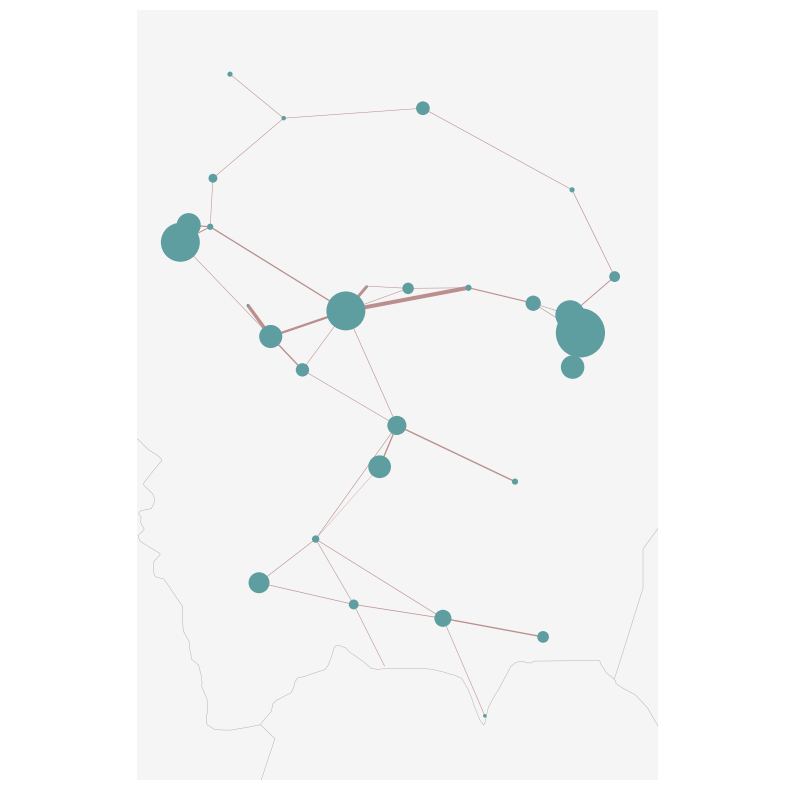

In [1703]:
max_node_size = 0.1  # maximum size of a node for plotting purposes [used in plots]

def normalize_node_size(values, max_node_size=max_node_size):
    return values / values.max() * max_node_size

fig, ax = plt.subplots(
    figsize=(10, 10),
    subplot_kw={
        "projection": ccrs.PlateCarree()
    },  # PlateCarree(default), Mercator, Orthographic
)

n = networks[first_year]

n.plot(
    margin=0.1,
    ax=None,
    geomap=True,  #'10m' leads to a beautiful high resolution map
    projection=None,
    bus_colors="cadetblue",
    bus_alpha=1,
    bus_sizes=normalize_node_size(
        n.loads_t.p_set.sum().rename("load").rename_axis("bus")
    ),
    bus_cmap=None,
    line_colors="rosybrown",
    link_colors="darkseagreen",  # loading
    transformer_colors="orange",
    line_widths=n.lines.s_nom_opt / 3e2,
    link_widths=1.5,
    transformer_widths=1.5,
    line_cmap=None,
    link_cmap=None,  # plt.cm.virdis (colordmap for line loading)
    transformer_cmap=None,
    flow=None,
    branch_components=None,
    layouter=None,
    title="",
    boundaries=None,
    geometry=False,
    jitter=None,
    color_geomap=True,
)  # None or True

ax.axis("off")
plt.show()

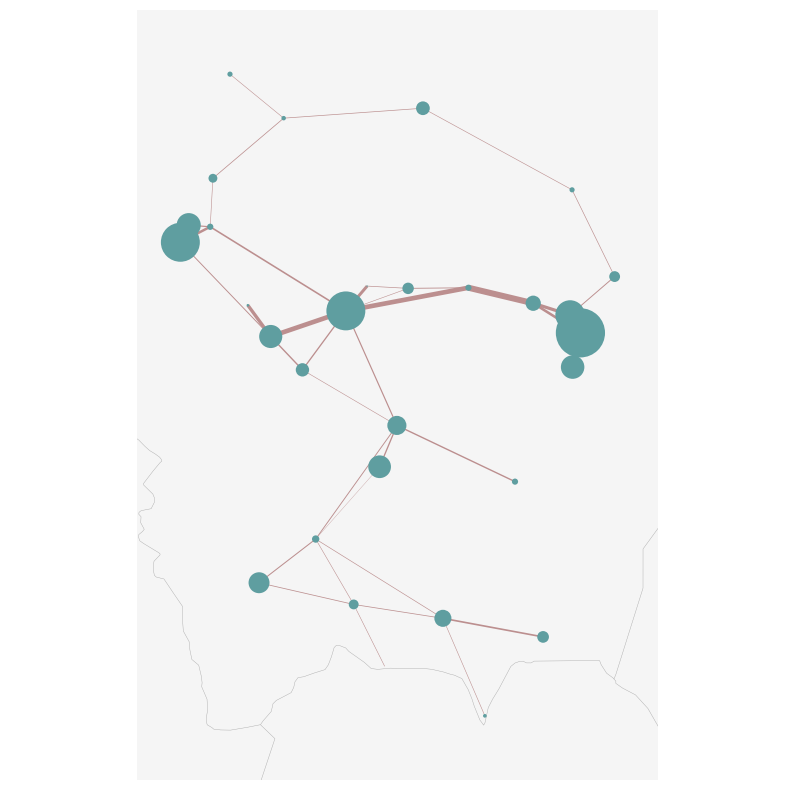

In [1704]:

fig, ax = plt.subplots(
    figsize=(10, 10),
    subplot_kw={
        "projection": ccrs.PlateCarree()
    },  # PlateCarree(default), Mercator, Orthographic
)

n = networks[final_year]

n.plot(
    margin=0.1,
    ax=None,
    geomap=True,  #'10m' leads to a beautiful high resolution map
    projection=None,
    bus_colors="cadetblue",
    bus_alpha=1,
    bus_sizes=normalize_node_size(
        n.loads_t.p_set.sum().rename("load").rename_axis("bus")
    ),
    bus_cmap=None,
    line_colors="rosybrown",
    link_colors="darkseagreen",  # loading
    transformer_colors="orange",
    line_widths=n.lines.s_nom_opt / 3e2,
    link_widths=1.5,
    transformer_widths=1.5,
    line_cmap=None,
    link_cmap=None,  # plt.cm.virdis (colordmap for line loading)
    transformer_cmap=None,
    flow=None,
    branch_components=None,
    layouter=None,
    title="",
    boundaries=None,
    geometry=False,
    jitter=None,
    color_geomap=True,
)  # None or True

ax.axis("off")
plt.show()

bus
BO0 0     4.857354e+04
BO0 1     4.346989e+03
BO0 10    1.018482e+02
BO0 11    9.948790e+05
BO0 12    2.281374e+02
BO0 13    2.431598e+02
BO0 14    8.638437e+05
BO0 15    6.257593e+05
BO0 16    7.042418e+01
BO0 17    5.213475e+01
BO0 18    1.872613e+06
BO0 19    2.827295e+04
BO0 2     4.841848e+01
BO0 20    3.767294e+01
BO0 21    8.299334e+05
BO0 22    8.500611e+01
BO0 23    4.704670e+06
BO0 24    6.176520e+03
BO0 25    1.334633e+05
BO0 26    9.672597e+01
BO0 27    1.935132e+02
BO0 28    5.567427e+05
BO0 29    2.981574e+05
BO0 3     2.103961e+06
BO0 4     1.592819e+06
BO0 5     1.357685e+06
BO0 6     8.200403e+01
BO0 7     1.013649e+06
BO0 8     7.244576e+01
BO0 9     1.343767e+06
Name: generation, dtype: float64


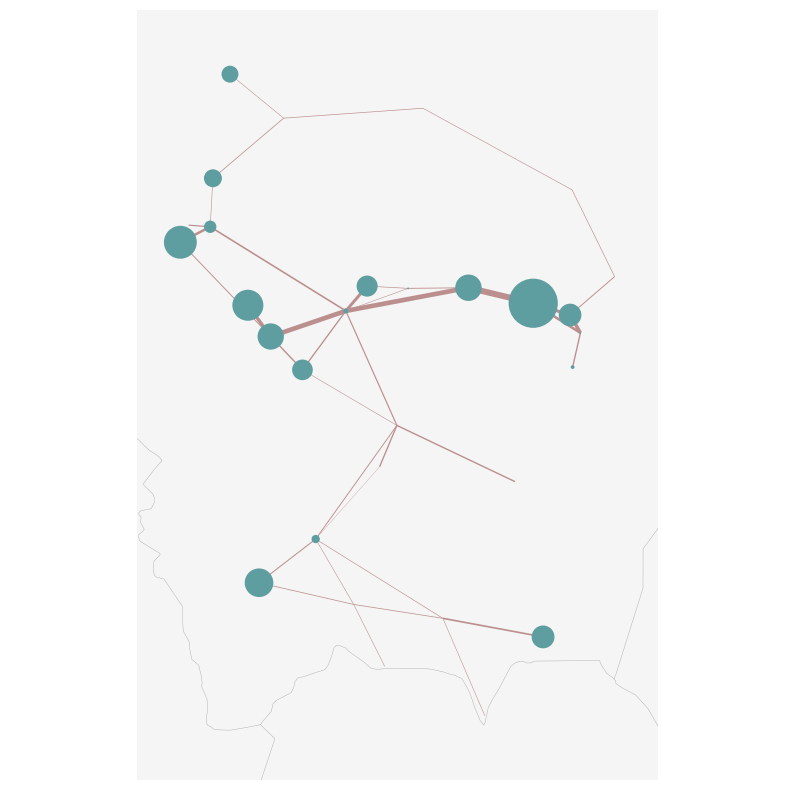

In [1705]:
n = networks[final_year]

# Sum the power generation for each generator over all timesteps
total_generation = n.generators_t.p.sum()
 
# Create a DataFrame by merging total generation with bus IDs for each generator
gen_to_bus = pd.DataFrame({'generation': total_generation}).merge(n.generators[['bus']], left_index=True, right_on='Generator')
 
# Group by 'bus' and sum the generation, resulting in a Series
gen_per_bus = gen_to_bus.groupby('bus')['generation'].sum()
 
# The result is a Series with 'bus' as the index and the summed generation as the values
print(gen_per_bus)

fig, ax = plt.subplots(
    figsize=(10, 10),
    subplot_kw={
        "projection": ccrs.PlateCarree()
    },  # PlateCarree(default), Mercator, Orthographic
)
 
 
n.plot(
    margin=0.1,
    ax=None,
    geomap=True,  #'10m' leads to a beautiful high resolution map
    projection=None,
    bus_colors="cadetblue",
    bus_alpha=1,
    bus_sizes=normalize_node_size(
        gen_per_bus
    ),
    bus_cmap=None,
    line_colors="rosybrown",
    link_colors="darkseagreen",  # loading
    transformer_colors="orange",
    line_widths=n.lines.s_nom_opt / 3e2,
    link_widths=1.5,
    transformer_widths=1.5,
    line_cmap=None,
    link_cmap=None,  # plt.cm.virdis (colordmap for line loading)
    transformer_cmap=None,
    flow=None,
    branch_components=None,
    layouter=None,
    title="",
    boundaries=None,
    geometry=False,
    jitter=None,
    color_geomap=True,
)  # None or True
 
ax.axis("off")
plt.show()

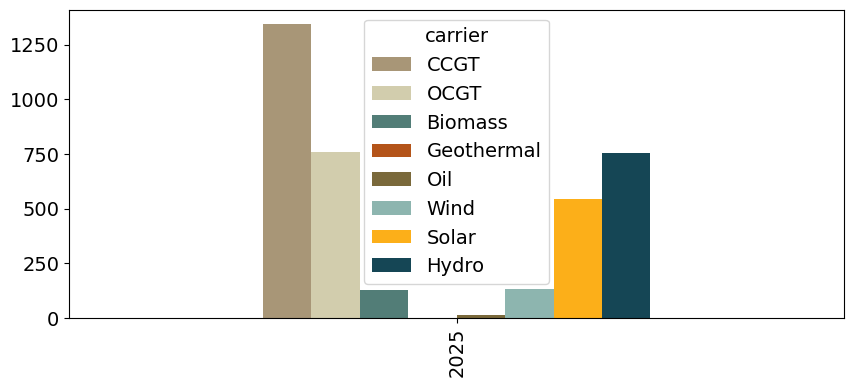

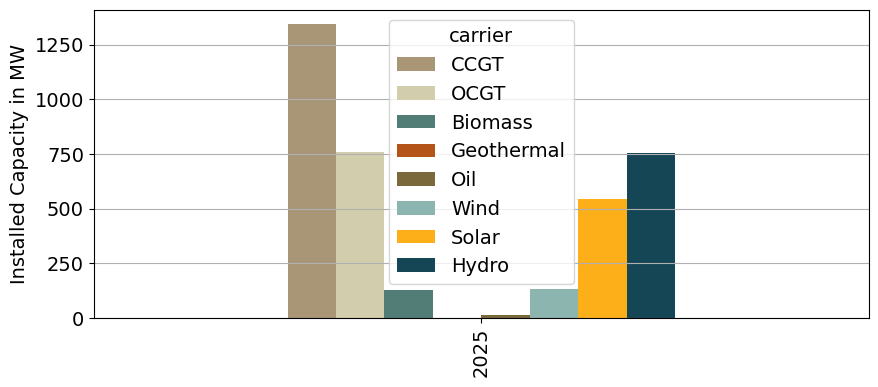

carrier         CCGT        OCGT     Biomass  Geothermal        Oil  \
2025     1343.070007  757.840036  127.720198    0.000094  12.000051   

carrier        Wind       Solar       Hydro  
2025     131.402283  545.121263  754.811612  


In [1706]:
installed_capacity_24 = get_installed_capacity(first_year)
installed_capacity_24.index = [first_year]
installed_capacity_24 = rename_columns(installed_capacity_24)
installed_capacity_24.plot(kind='bar',color=get_colors(installed_capacity_24.columns),figsize=(10, 4), legend=True)
if save_to_csv:
    installed_capacity_24.to_csv(path + 'result_data/' + case_path + '_24' + '_final_capacity.csv')
installed_capacity_24.plot(kind='bar',color=get_colors(installed_capacity_24.columns),figsize=(10, 4), legend=True)

plt.ylabel('Installed Capacity in MW')
#plt.ylim(0,5500)
plt.grid(axis='y')
plt.show()

print(installed_capacity_24)

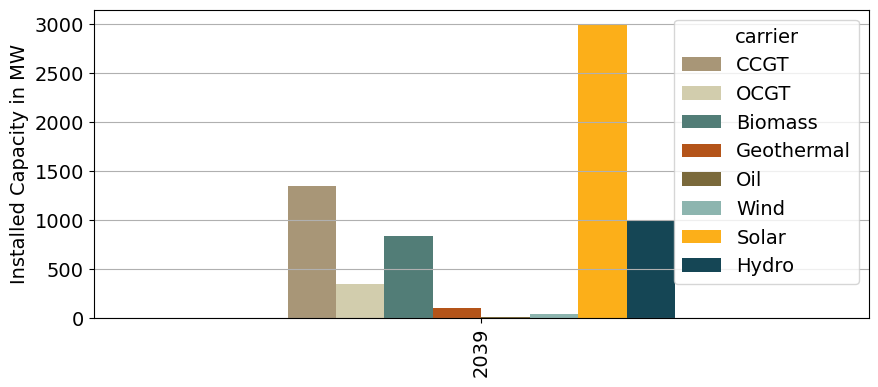

carrier         CCGT       OCGT     Biomass  Geothermal       Oil       Wind  \
2039     1343.071289  340.93438  839.999799  100.004349  6.464464  42.955309   

carrier        Solar  Hydro  
2039     2996.162781  994.3  


In [1707]:
installed_capacity_37 = get_installed_capacity(final_year)
installed_capacity_37.index = [final_year]
installed_capacity_37 = rename_columns(installed_capacity_37)
if save_to_csv:
    installed_capacity_37.to_csv(path + 'result_data/' + case_path + '_final_capacity.csv')
installed_capacity_37.plot(kind='bar',color=get_colors(installed_capacity_37.columns),figsize=(10, 4), legend=True)

plt.ylabel('Installed Capacity in MW')
plt.grid(axis='y')
#plt.ylim(0,5500)
plt.show()
print(installed_capacity_37)

In [1708]:
installed_lines_first_year = get_installed_capacity_lines(first_year)
# Ensure installed_lines_first_year is a DataFrame with appropriate structure
installed_lines_df = pd.DataFrame(installed_lines_first_year).T
installed_lines_df.index = [first_year]  # Set the index to first_year for clear identification

file_path = path + 'result_data/installed_lines_first_year.csv'

if save_to_csv:
    try:
        # Load the existing data
        df = pd.read_csv(file_path, index_col=0)  # Assuming the first column is a suitable index, typically year or similar identifier
    except FileNotFoundError:
        # Initialize an empty DataFrame if the file doesn't exist
        df = pd.DataFrame()

    # Check if the case_path column exists, if not, append it
    if case_path not in df.columns:
        df[case_path] = pd.NA  # Initializes the column with missing values

    # Update or insert the new value(s)
    for year in installed_lines_df.index:
        df.loc[year, case_path] = installed_lines_df.loc[year].values[0]

    # Reset index before saving if you want the year as the first column instead of the index
    df.reset_index().to_csv(file_path, index=False)


In [1709]:
installed_lines_final_year = get_installed_capacity_lines(final_year)
# Ensure installed_lines_final_year is a DataFrame with appropriate structure
installed_lines_df = pd.DataFrame(installed_lines_final_year).T
installed_lines_df.index = [final_year]  # Set the index to final_year for clear identification

file_path = path + 'result_data/installed_lines_final_year.csv'


if save_to_csv:
    try:
        # Load the existing data
        df = pd.read_csv(file_path, index_col=0)  # Assuming the first column is a suitable index, typically year or similar identifier
    except FileNotFoundError:
        # Initialize an empty DataFrame if the file doesn't exist
        df = pd.DataFrame()

    # Check if the case_path column exists, if not, append it
    if case_path not in df.columns:
        df[case_path] = pd.NA  # Initializes the column with missing values

    # Update or insert the new value(s)
    for year in installed_lines_df.index:
        df.loc[year, case_path] = installed_lines_df.loc[year].values[0]

    # Reset index before saving if you want the year as the first column instead of the index
    df.reset_index().to_csv(file_path, index=False)

In [1710]:
yearly_difference = False
if yearly_difference:
    installed_capacities = []
    for year in years:
        year_capacity_df = get_installed_capacity(year)
        installed_capacities.append(year_capacity_df)

    all_capacities = pd.concat(installed_capacities)
    year_over_year_diff = all_capacities.diff().dropna()
    year_over_year_diff = rename_columns(year_over_year_diff)

    year_over_year_diff.plot(kind='bar', figsize=(12, 6), color=get_colors(year_over_year_diff.columns))
    plt.title('Year-over-Year Differences in Installed Capacity')
    plt.ylabel('Difference in Installed Capacity (MW)')
    plt.xlabel('Year')
    #plt.ylim(0, 10)
    plt.show()

3978.0668212376745


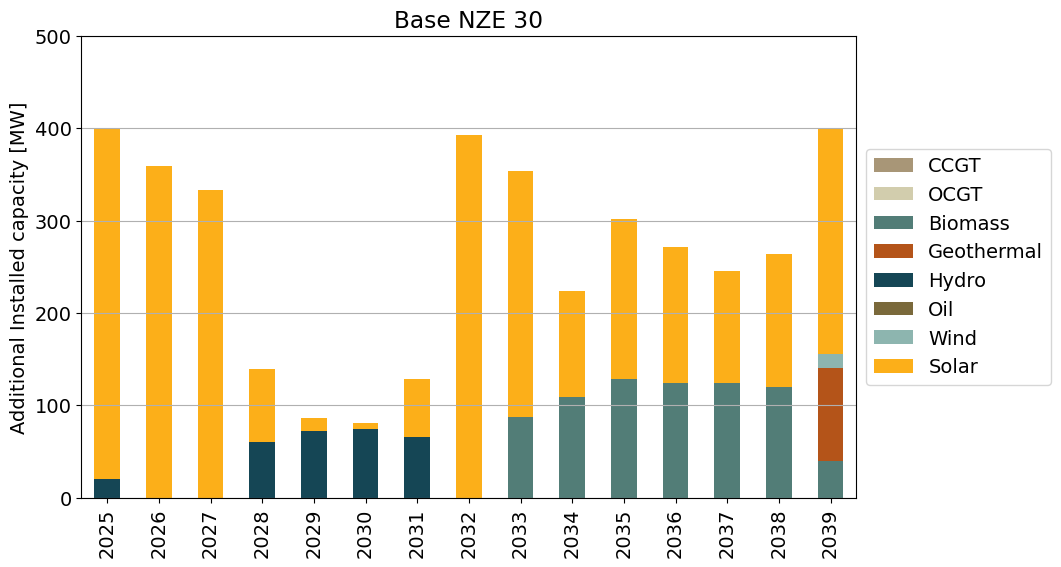

In [1711]:
grouped_cap_change_B = get_new_installed(years)
grouped_cap_change_B = rename_columns(grouped_cap_change_B)
if save_to_csv:
    grouped_cap_change_B.to_csv(path + 'result_data/' + case_path + '_new_capacity.csv')
grouped_cap_change_B.plot.bar(stacked=True, figsize=(10, 6),color=get_colors(grouped_cap_change_B.columns), legend=True)

print(grouped_cap_change_B.sum().sum())

plt.ylabel('Additional Installed capacity [MW]')
plt.xlabel('')
plt.xticks(range(len(grouped_cap_change_B.index)), grouped_cap_change_B.index, rotation=90)
plt.title(case)
plt.ylim(0, 500)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid(axis = 'y',zorder = 0)
#plt.savefig(path_fig + 'new_capacity.png', dpi=300, bbox_inches='tight')

In [1712]:
# installed_per_period = []
# for i in range(3):
#     installed_per_period.append(grouped_cap_change_B.iloc[i*5:(i+1)*5].sum())
# installed_per_period = pd.DataFrame(installed_per_period)
# installed_per_period.plot.bar(stacked=True, figsize=(10, 6),color=get_colors(installed_per_period.columns), legend=True)

# plt.ylabel('Additional Installed capacity [MW]')
# plt.xlabel('')
# plt.title(case)
# plt.ylim(0, 3000)
# plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
# plt.grid(axis = 'y',zorder = 0)

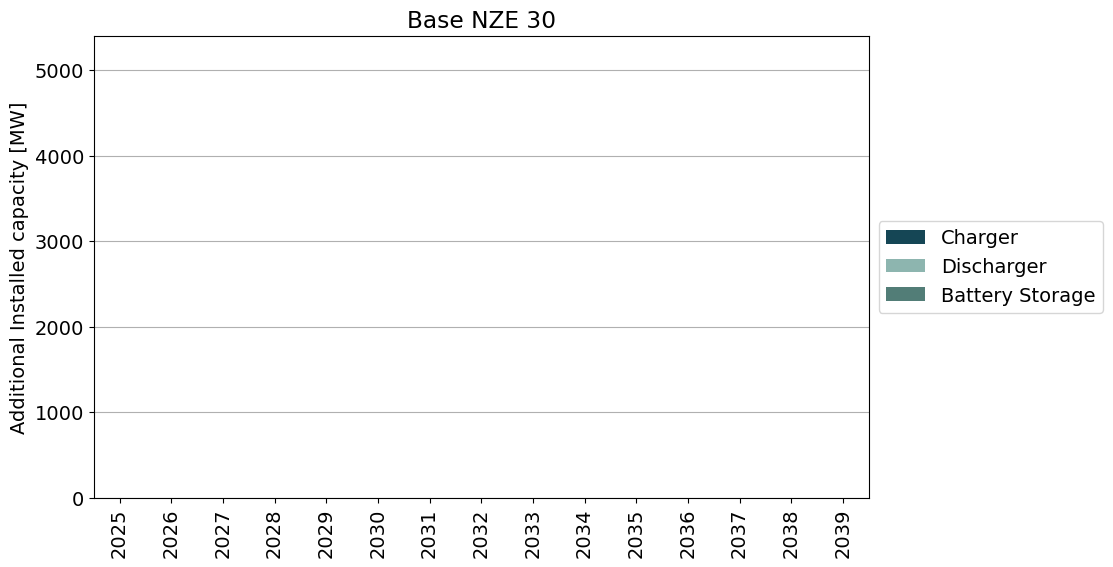

In [1713]:
battery_change = get_new_installed_battery(years)
if save_to_csv:
    battery_change.to_csv(path + 'result_data/' + case_path + '_new_battery_capacity.csv')
#battery_change = rename_columns(battery_change)
battery_change.plot.bar(stacked=True, figsize=(10, 6),color=[teal2, teal4, teal3])

plt.ylabel('Additional Installed capacity [MW]')
plt.xlabel('')
plt.xticks(range(len(battery_change.index)), battery_change.index, rotation=90)
plt.title(case)
plt.ylim(0, 5400)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid(axis = 'y',zorder = 0)
#plt.savefig(path_fig + 'new_battery_capacity.png', dpi=300, bbox_inches='tight')

In [1714]:
# line_change = get_new_installed_lines(years)
# if save_to_csv:
#     line_change.to_csv(path + 'result_data/' + case_path + '_new_line_capacity.csv')
# #battery_change = rename_columns(battery_change)
# line_change.plot.bar(stacked=True, figsize=(10, 6),color=beige2, legend=False)

# plt.ylabel('Additional Installed capacity [MW]')
# plt.xlabel('')
# plt.xticks(range(len(line_change.index)), line_change.index, rotation=90)
# plt.title(case)
# plt.ylim(0, 2000)
# #plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
# plt.grid(axis = 'y',zorder = 0)

In [1715]:
# installed_line_per_period = []
# for i in range(3):
#     installed_line_per_period.append(line_change.iloc[i*5:(i+1)*5].sum())
# installed_line_per_period = pd.DataFrame(installed_line_per_period)
# installed_line_per_period.plot.bar(stacked=True, figsize=(10, 6),color=beige2, legend=False)

# plt.ylabel('Additional Installed capacity [MW]')
# plt.xlabel('')
# plt.title(case)
# plt.ylim(0, 2500)
# plt.grid(axis = 'y',zorder = 0)

          CCGT      OCGT           Oil    Geothermal     Hydro      Wind  \
2025  6.335093  0.005402  8.215436e-07  5.493475e-07  3.528297  0.200872   
2026  6.075592  0.009929  7.005295e-07  6.093970e-07  3.528316  0.200872   
2027  5.818461  0.012612  8.332025e-07  7.200026e-07  3.520844  0.200663   
2028  5.561754  0.014862  8.766458e-05  9.695756e-07  4.042708  0.200836   
2029  5.307407  0.015360  1.039581e-04  1.244699e-06  4.681811  0.200872   
2030  5.054686  0.014609  1.072602e-04  2.607220e-06  5.327758  0.200872   
2031  4.801442  0.014253  1.203456e-04  2.941746e-06  5.878082  0.200872   
2032  4.551871  0.011108  7.581022e-05  3.819236e-06  5.872143  0.192447   
2033  4.295315  0.013395  3.206946e-05  4.251970e-06  5.880614  0.180159   
2034  4.039932  0.014685  6.114424e-05  4.461556e-06  5.882373  0.181748   
2035  3.786244  0.014708  4.547944e-05  4.886733e-06  5.835916  0.006330   
2036  3.527681  0.018439  1.003943e-04  5.327436e-06  5.767740  0.006316   
2037  3.2744

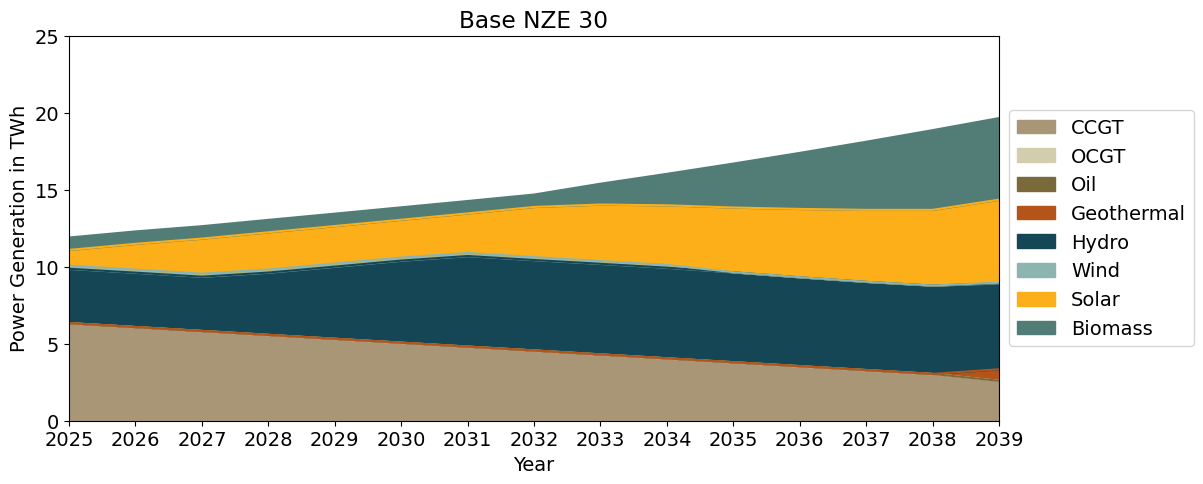

In [1716]:
production_sources = [get_power_prod(year) for year in years]
production = pd.concat(production_sources)
production.index = years
production = production.astype('float32')

if 'load' in production:
  production.drop('load', axis=1, inplace=True)

#production['hydro'] += production.pop('ror')
#print(production)
production = rename_columns(production)
if save_to_csv:
  production.to_csv(path + 'result_data/' + case_path + '_production.csv')
production.plot.area(stacked=True, color=get_colors(production.columns),figsize=(12, 5))

plt.xticks(years, [int(year) for year in years])
plt.ylabel('Power Generation in TWh')
plt.xlabel('Year')
plt.xlim(first_year,final_year)
plt.ylim(0,25)
plt.title(case)
#plt.xticks(range(len(years)), years)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
#plt.savefig(path_fig + 'power_generation.png', dpi=300, bbox_inches='tight')
print(production)

         CCGT      OCGT           oil    geothermal     hydro    onwind  \
2025  0.53254  0.000454  6.906052e-08  4.617920e-08  0.296595  0.016886   

         solar   biomass  
2025  0.085808  0.067717  


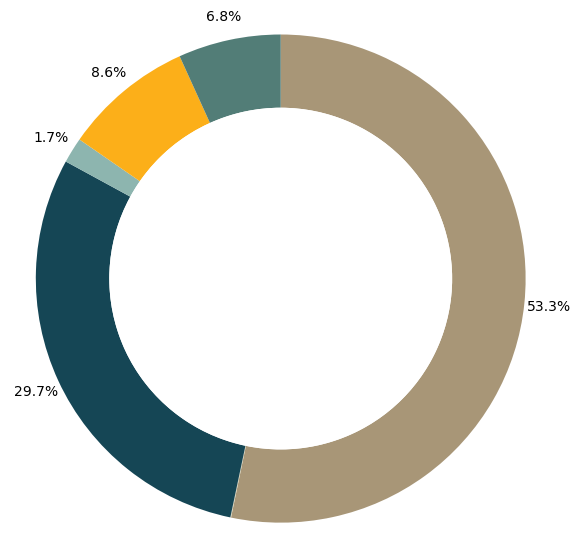

In [1717]:
power_mix_df = get_power_mix(first_year)
print(power_mix_df)
plt.rcParams['font.size'] = 10
power_mix_df = rename_columns(power_mix_df)
fig, ax = plt.subplots(figsize=(7, 7))
wedges, texts, autotexts = ax.pie(power_mix_df.iloc[0].values, autopct=custom_autopct, colors=get_colors(power_mix_df.columns), startangle=90, counterclock=False, wedgeprops=dict(width=0.3), pctdistance=1.1)

# Hide the zero-value autotexts
for autotext in autotexts:
    if autotext.get_text() <= '0.3%':
        autotext.set_visible(False)

ax.axis('equal')
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig.gca().add_artist(centre_circle)
#plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
#plt.title(case + ' Power Mix '+ str(first_year), fontsize=15)
#plt.legend(power_mix_df.columns, bbox_to_anchor=(1, 0.5))
plt.show()

          CCGT      OCGT       oil  geothermal     hydro   onwind     solar  \
2039  0.131208  0.000602  0.000004    0.038177  0.284077  0.00175  0.274616   

       biomass  
2039  0.269566  


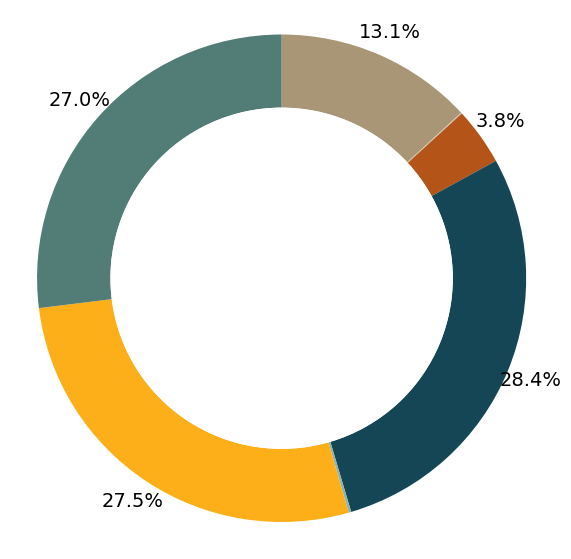

In [1718]:
power_mix_df = get_power_mix(final_year)
print(power_mix_df)
plt.rcParams['font.size'] = 14
power_mix_df = rename_columns(power_mix_df)
if save_to_csv:
    try:
        df = pd.read_csv(path + 'result_data/power_mix_final.csv')
    except FileNotFoundError:
        df = pd.DataFrame()
    df[case_path] = power_mix_df.iloc[0]
    df.to_csv(path + 'result_data/power_mix_final.csv', index=False)
fig, ax = plt.subplots(figsize=(7, 7))
wedges, texts, autotexts = ax.pie(power_mix_df.iloc[0].values, autopct=custom_autopct, colors=get_colors(power_mix_df.columns), startangle=90, counterclock=False, wedgeprops=dict(width=0.3), pctdistance=1.1)

# Hide the zero-value autotexts
for autotext in autotexts:
    if autotext.get_text() <= '0.3%':
        autotext.set_visible(False)

ax.axis('equal')
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig.gca().add_artist(centre_circle)

#plt.title(case + ' Power Mix ' + str(final_year), fontsize=15)
#plt.legend(power_mix_df.columns, bbox_to_anchor=(1, 0.5))
#plt.savefig(path_fig + 'power_mix_37.png', dpi=300, bbox_inches='tight')
plt.show()

          CCGT      OCGT       oil  geothermal     hydro   onwind     solar  \
2039  0.131208  0.000602  0.000004    0.038177  0.284077  0.00175  0.274616   

       biomass  
2039  0.269566  


Text(0.5, 0.98, 'Base NZE 30')

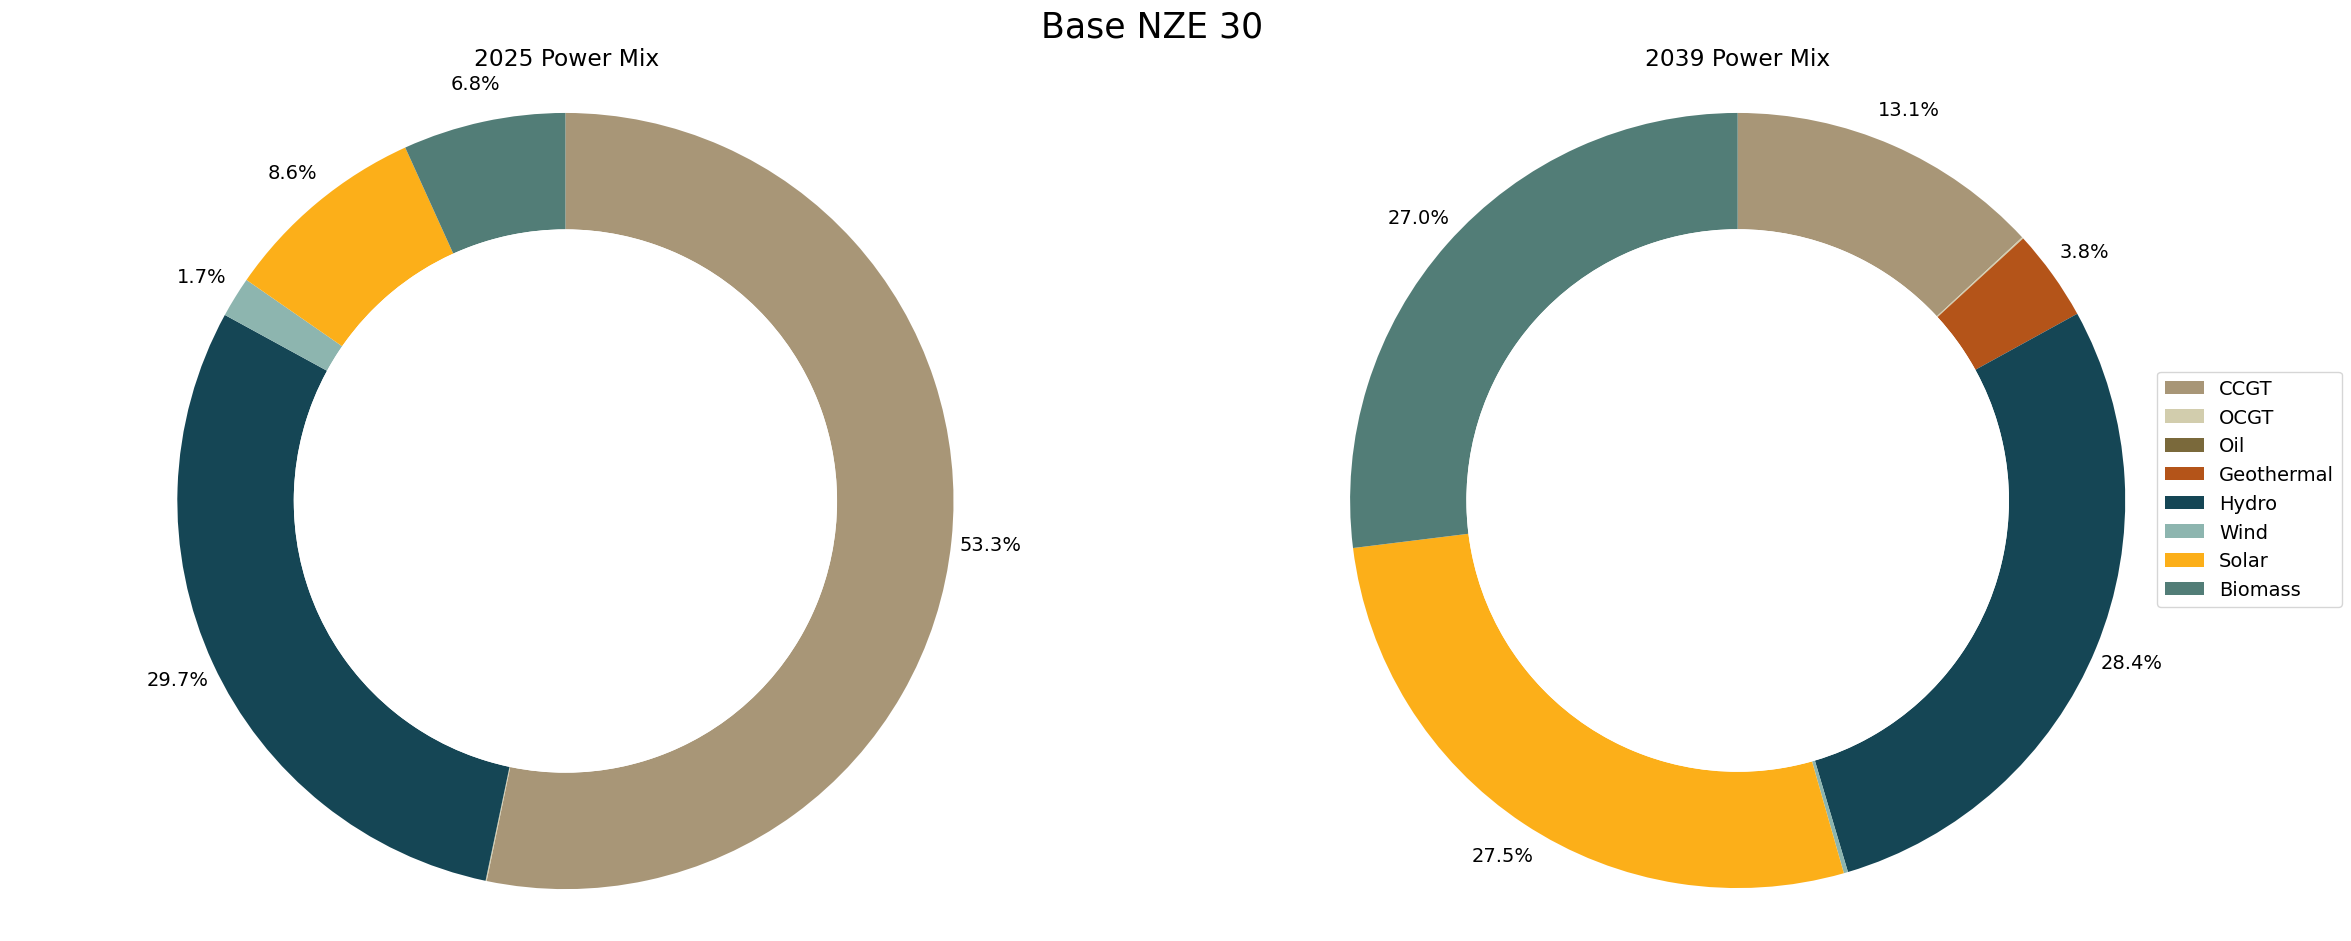

In [1719]:
power_mix_first = get_power_mix(first_year)
power_mix_final = get_power_mix(final_year)
print(power_mix_final)

plt.rcParams['font.size'] = 14
power_mix_first = rename_columns(power_mix_first)
power_mix_final = rename_columns(power_mix_final)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 10))

wedges1, texts1, autotexts1 = ax1.pie(
    power_mix_first.iloc[0].values, autopct=custom_autopct,
    colors=get_colors(power_mix_first.columns), startangle=90, counterclock=False, 
    wedgeprops=dict(width=0.3), pctdistance=1.1
)

wedges2, texts2, autotexts2 = ax2.pie(
    power_mix_final.iloc[0].values, autopct=custom_autopct,
    colors=get_colors(power_mix_final.columns), startangle=90, counterclock=False, 
    wedgeprops=dict(width=0.3), pctdistance=1.1
)

for autotext in autotexts1 + autotexts2:
    if autotext.get_text() <= '0.3%':
        autotext.set_visible(False)

centre_circle1 = plt.Circle((0,0),0.70,fc='white')
ax1.add_artist(centre_circle1)
ax1.set_title(str(first_year) +' Power Mix')

centre_circle2 = plt.Circle((0,0),0.70,fc='white')
ax2.add_artist(centre_circle2)
ax2.set_title(str(final_year) +' Power Mix')

ax1.axis('equal')
ax2.axis('equal')

fig.legend(power_mix_first.columns, loc="center right", bbox_to_anchor=(1, 0.5))
plt.tight_layout(pad=3.0)
fig.suptitle(case, fontsize=25)
#plt.savefig(path_fig + 'power_mix.png', dpi=300, bbox_inches='tight')

In [1720]:
# PyPSA OG method

if PyPSA_OG:
    
    new_installed_cap = get_new_installed_hydro(years)
    new_installed_bat = get_new_installed_battery(years)
    new_installed_lines = get_new_installed_lines(years)
    capital_cost_lines = capcost_lines(2029)

    capital_costs_1 = []
    accumulated_new_cap = []
    capital_cost_by_type = []
    capital_cost_by_type_empire = []

    gen_capex_empire = 0
    bat_capex_empire = 0
    line_capex_empire = 0

    for y in years:

        network = networks[y]
        total_capex = 0

        if y == 2025 or y == 2030 or y == 2035:
            gen_capex_empire = 0
            bat_capex_empire = 0
            line_capex_empire = 0

        for carrier in new_installed_cap.columns:
            accumulated_new_cap = new_installed_cap.loc[: y, carrier].sum()
            capex_value = accumulated_new_cap *  capital_cost_df.loc[carrier, 'capital_cost']
            total_capex += capex_value
            gen_capex_empire += capex_value


        bat_capex = new_installed_bat.loc[:y, 'Battery Storage'].sum() * capital_cost_df.loc['battery storage', 'capital_cost']
        bat_capex_empire += calculate_present_value(new_installed_bat.loc[:y, 'Battery Storage'].sum() * network.stores.loc[network.stores['carrier'] == 'battery', 'capital_cost'].iloc[0],y,first_year)  
        bat_capex += new_installed_bat.loc[:y, 'Charger'].sum() * capital_cost_df.loc['battery inverter', 'capital_cost']
        bat_capex_empire += calculate_present_value(new_installed_bat.loc[:y, 'Charger'].sum() * network.links.loc[network.links['carrier'] == 'battery charger', 'capital_cost'].iloc[0],y,first_year)
        bat_capex += new_installed_bat.loc[:y, 'Discharger'].sum() * capital_cost_df.loc['battery inverter', 'capital_cost']
        bat_capex_empire += calculate_present_value(new_installed_bat.loc[:y, 'Discharger'].sum() * network.links.loc[network.links['carrier'] == 'battery discharger', 'capital_cost'].iloc[0],y,first_year)

        for line in new_installed_lines.columns:
            line_capex = new_installed_lines.loc[:y, str(line)].sum() * capital_cost_lines.loc[line, 'capital_cost']
            total_capex += line_capex
            line_capex_empire += calculate_present_value(line_capex,y,first_year)
        # line_capex = new_installed_lines.loc[:y, 'Line'].sum() * network.lines.loc[network.lines['carrier'] == 'AC', 'capital_cost'].iloc[0]
        # line_capex_empire += calculate_present_value(new_installed_lines.loc[:y, 'Line'].sum() * network.lines.loc[network.lines['carrier'] == 'AC', 'capital_cost'].iloc[0],y,first_year)
        total_capex += bat_capex

        capital_costs_1.append(total_capex/1e6)
        capital_cost_by_type.append({'Period': y, 'Type': 'Generators', 'Investment': calculate_present_value(capex_value,y,first_year)/1e6})
        capital_cost_by_type.append({'Period': y, 'Type': 'Storage', 'Investment': calculate_present_value(bat_capex,y,first_year)/1e6})
        capital_cost_by_type.append({'Period': y, 'Type': 'Transmission Lines', 'Investment': calculate_present_value(line_capex,y,first_year)/1e6})

        if y == 2029 or y == 2034 or y == 2039:
            capital_cost_by_type_empire.append({'Period': y, 'Type': 'Generators', 'Investment': gen_capex_empire/1e6})
            capital_cost_by_type_empire.append({'Period': y, 'Type': 'Storage', 'Investment': bat_capex_empire/1e6})
            capital_cost_by_type_empire.append({'Period': y, 'Type': 'Transmission Lines', 'Investment': line_capex_empire/1e6})

    pv_capital_costs = [calculate_present_value(i, year, years[0], 0.04) for i, year in zip(capital_costs_1, years)]
    capital_cost_by_type_df = pd.DataFrame(capital_cost_by_type)
    capital_cost_by_type_empire_df = pd.DataFrame(capital_cost_by_type_empire)
    operational_costs = get_operational_costs(years)
    pv_operational_costs = [calculate_present_value(i, year, years[0], 0.04) for i, year in zip(operational_costs, years)]

    # repeat_indices = [4, 9, 14]
    # final_adjusted_opex = []

    # # Process each year and check if the index is in repeat_indices
    # for i, year in enumerate(years):
    #     if i in repeat_indices:
    #         # Add the same value for the four preceding years plus the current year
    #         final_adjusted_opex.extend([opex[i]] * 5)
    #     elif not any((i >= idx - 4 and i < idx) for idx in repeat_indices):
    #         # Only add the current year's opex if it's not in the range that should be replaced by a repeat
    #         final_adjusted_opex.append(opex[i])

    # pv_opex = [calculate_present_value(o, year, years[0], 0.04) for o, year in zip(opex, years)]

    if save_to_csv:
        try:
            capcost_df = pd.read_csv(path + 'result_data/capcost.csv')
            opex_df = pd.read_csv(path + 'result_data/opex.csv')
        except FileNotFoundError:
            capcost_df = pd.DataFrame()
            opex_df = pd.DataFrame()
        
        capcost_df[case_path] = pv_capital_costs
        opex_df[case_path] = pv_operational_costs

        capcost_df.to_csv(path + 'result_data/capcost.csv', index=False)
        opex_df.to_csv(path + 'result_data/opex.csv', index=False)

In [1721]:
# PyPSA compare method

if PyPSA_compare:

    new_installed_cap = get_new_installed_hydro(years)
    new_installed_bat = get_new_installed_battery(years)
    new_installed_lines = get_new_installed_lines(years)
    capital_cost_lines = capcost_lines(2029)

    def empire_factor(y,lifetime):
        return (1-(1+discountrate)**-min((years[-1]-y+1,lifetime)))/(1-(1+discountrate)**-1)


    first_year_empire = 2025
    capital_costs_2 = []
    capital_cost_by_type = []
    capital_cost_by_type_empire = []

    for y in years:

        network = networks[y]
        total_capex = 0
        gen_capex = 0
        bat_capex = 0
        line_capex = 0


        for carrier in new_installed_cap.columns:
            empire_factor_value = empire_factor(y, costs_pivot.at[carrier, 'lifetime'])
            capex_value = new_installed_cap.loc[y, carrier] * capital_cost_df.loc[carrier, 'capital_cost'] * empire_factor_value
            total_capex += capex_value
            gen_capex_empire += capex_value

        bat_capex += new_installed_bat.loc[y, 'Battery Storage'] * capital_cost_df.loc['battery storage', 'capital_cost'] * empire_factor(y, costs_pivot.at['battery storage', 'lifetime'])
        bat_capex += new_installed_bat.loc[y, 'Charger'] * capital_cost_df.loc['battery inverter', 'capital_cost'] * empire_factor(y, costs_pivot.at['battery inverter', 'lifetime'])
        bat_capex += new_installed_bat.loc[y, 'Discharger'] * capital_cost_df.loc['battery inverter', 'capital_cost'] * empire_factor(y, costs_pivot.at['battery inverter', 'lifetime'])
        for line in new_installed_lines.columns:
            empire_factor_value = empire_factor(period, costs_pivot.at['HVAC overhead', 'lifetime'])
            capex_value = new_installed_lines.loc[y, str(line)] * capital_cost_lines.loc[line, 'capital_cost'] * empire_factor_value
            line_capex += capex_value

        total_capex += bat_capex + line_capex
        capital_costs_2.append(total_capex/1e6)
        capital_cost_by_type.append({'Period': y, 'Type': 'Generators', 'Investment': calculate_present_value(gen_capex,y,first_year_empire)/1e6})
        capital_cost_by_type.append({'Period': y, 'Type': 'Storage', 'Investment': calculate_present_value(bat_capex,y,first_year_empire)/1e6})
        capital_cost_by_type.append({'Period': y, 'Type': 'Transmission Lines', 'Investment': calculate_present_value(line_capex,y,first_year_empire)/1e6})

    capital_cost_by_type_df = pd.DataFrame(capital_cost_by_type)
    pv_capital_costs = [calculate_present_value(i, year, years[0], 0.04) for i, year in zip(capital_costs_2, years)]

    opex = [networks[year].statistics.opex().sum() / 1e6 for year in years]

    repeat_indices = [4, 9, 14]
    final_adjusted_opex = []

    # Process each year and check if the index is in repeat_indices
    for i, year in enumerate(years):
        if i in repeat_indices:
            # Add the same value for the four preceding years plus the current year
            final_adjusted_opex.extend([opex[i]] * 5)
        elif not any((i >= idx - 4 and i < idx) for idx in repeat_indices):
            # Only add the current year's opex if it's not in the range that should be replaced by a repeat
            final_adjusted_opex.append(opex[i])
    
    pv_opex = [calculate_present_value(i, year, years[0], 0.04) for i, year in zip(opex, years)]

    if save_to_csv:
        try:
            capcost_df = pd.read_csv(path + 'result_data/capcost.csv')
            opex_df = pd.read_csv(path + 'result_data/opex.csv')
        except FileNotFoundError:
            capex_df = pd.DataFrame()
            opex_df = pd.DataFrame()
        
        capcost_df[case_path] = pv_capital_costs
        opex_df[case_path] = pv_opex

        capcost_df.to_csv(path + 'result_data/capcost.csv', index=False)
        opex_df.to_csv(path + 'result_data/opex.csv', index=False)


In [1722]:
# Empire method

if Empire:

    def empire_factor(period,lifetime):
        return (1-(1+discountrate)**-min((3-period+1)*5,lifetime))/(1-(1+discountrate)**-1)

    first_year_empire = 2025
    capital_costs_3 = []

    new_installed_cap = get_new_installed_hydro(years)
    new_installed_bat = get_new_installed_battery(years)
    new_installed_lines = get_new_installed_lines(years)
    capital_cost_lines = capcost_lines(2029)
    capital_cost_by_type = []
    period = 1

    for y in years:

        network = networks[y]
        if y == 2025 or y == 2030 or y == 2035:
            gen_capex = 0
            bat_capex = 0
            line_capex = 0

        if 2029 < y < 2035:
            period = 2
        elif y >= 2035:
            period = 3

        for carrier in new_installed_cap.columns:
            empire_factor_value = empire_factor(period, costs_pivot.at[carrier, 'lifetime'])
            capex_value = new_installed_cap.loc[y, carrier] * capital_cost_df.loc[carrier, 'capital_cost'] * empire_factor_value
            gen_capex += capex_value

        bat_capex += new_installed_bat.loc[y, 'Battery Storage'] * capital_cost_df.loc['battery storage', 'capital_cost'] * empire_factor(period, costs_pivot.at['battery storage', 'lifetime'])
        bat_capex += new_installed_bat.loc[y, 'Charger'] * capital_cost_df.loc['battery inverter', 'capital_cost'] * empire_factor(period, costs_pivot.at['battery inverter', 'lifetime'])
        bat_capex += new_installed_bat.loc[y, 'Discharger'] * capital_cost_df.loc['battery inverter', 'capital_cost'] * empire_factor(period, costs_pivot.at['battery inverter', 'lifetime'])
        for line in new_installed_lines.columns:
            empire_factor_value = empire_factor(period, costs_pivot.at['HVAC overhead', 'lifetime'])
            capex_value = new_installed_lines.loc[y, str(line)] * capital_cost_lines.loc[line, 'capital_cost'] * empire_factor_value
            line_capex += capex_value
    

        if y == 2029 or y == 2034 or y == 2039:
            capital_costs_3.append((gen_capex + bat_capex + line_capex)/1e6)
            capital_cost_by_type.append({'Period': y, 'Type': 'Generators', 'Investment': calculate_present_value(gen_capex,y,first_year_empire)/1e6})
            capital_cost_by_type.append({'Period': y, 'Type': 'Storage', 'Investment': calculate_present_value(bat_capex,y,first_year_empire)/1e6})
            capital_cost_by_type.append({'Period': y, 'Type': 'Transmission Lines', 'Investment': calculate_present_value(line_capex,y,first_year_empire)/1e6})
            for i in range(4):
                capital_costs_3.append(0)

    capital_cost_by_type_df = pd.DataFrame(capital_cost_by_type)
    pv_capital_costs = [calculate_present_value(i, year, years[0], 0.04) for i, year in zip(capital_costs_3, years)]

    opex = [networks[year].statistics.opex().sum() / 1e6 for year in years]
    repeat_indices = [4, 9, 14]
    final_adjusted_opex = []

    for i, year in enumerate(years):
        if i in repeat_indices:
            # Add the same value for the four preceding years plus the current year
            final_adjusted_opex.extend([opex[i]] * 5)
        elif not any((i >= idx - 4 and i < idx) for idx in repeat_indices):
            # Only add the current year's opex if it's not in the range that should be replaced by a repeat
            final_adjusted_opex.append(opex[i])
    
    pv_opex = [calculate_present_value(i, year, first_year_empire, 0.04) for i, year in zip(final_adjusted_opex, years)]

    if save_to_csv:
        try:
            capcost_df = pd.read_csv(path + 'result_data/capcost.csv')
            opex_df = pd.read_csv(path + 'result_data/opex.csv')
        except FileNotFoundError:
            capex_df = pd.DataFrame()
            opex_df = pd.DataFrame()
        
        capcost_df[case_path] = pv_capital_costs
        opex_df[case_path] = pv_opex

        capcost_df.to_csv(path + 'result_data/capcost.csv', index=False)
        opex_df.to_csv(path + 'result_data/opex.csv', index=False)


In [1723]:
# Empire method for validation

if Empire_validering:

    def empire_factor(period,lifetime):
        return (1-(1+discountrate)**-min((3-period+1)*5,lifetime))/(1-(1+discountrate)**-1)

    capital_costs_3 = []

    new_installed_cap = get_new_installed_hydro(years)
    new_installed_bat = get_new_installed_battery(years)
    new_installed_lines = get_new_installed_lines(years)
    capital_cost_lines = capcost_lines(2029)
    capital_cost_by_type = []
    period = 1

    for y in years:

        network = networks[y]
   
        gen_capex = 0
        bat_capex = 0
        line_capex = 0

        if 2029 < y < 2035:
            period = 2
        elif y >= 2035:
            period = 3

        for carrier in new_installed_cap.columns:
            empire_factor_value = empire_factor(period, costs_pivot.at[carrier, 'lifetime'])
            capex_value = new_installed_cap.loc[y, carrier] * capital_cost_df.loc[carrier, 'capital_cost'] * empire_factor_value
            gen_capex += capex_value

        bat_capex += new_installed_bat.loc[y, 'Battery Storage'] * capital_cost_df.loc['battery storage', 'capital_cost'] * empire_factor(period, costs_pivot.at['battery storage', 'lifetime'])
        bat_capex += new_installed_bat.loc[y, 'Charger'] * capital_cost_df.loc['battery inverter', 'capital_cost'] * empire_factor(period, costs_pivot.at['battery inverter', 'lifetime'])
        bat_capex += new_installed_bat.loc[y, 'Discharger'] * capital_cost_df.loc['battery inverter', 'capital_cost'] * empire_factor(period, costs_pivot.at['battery inverter', 'lifetime'])

        for line in new_installed_lines.columns:
            empire_factor_value = empire_factor(period, costs_pivot.at['HVAC overhead', 'lifetime'])
            capex_value = new_installed_lines.loc[y, str(line)] * capital_cost_lines.loc[line, 'capital_cost'] * empire_factor_value
            line_capex += capex_value


        capital_costs_3.append((gen_capex + bat_capex + line_capex)/1e6)
        capital_cost_by_type.append({'Period': y, 'Type': 'Generators', 'Investment': calculate_present_value(gen_capex,y-4,first_year_empire)/1e6})
        capital_cost_by_type.append({'Period': y, 'Type': 'Storage', 'Investment': calculate_present_value(bat_capex,y-4,first_year_empire)/1e6})
        capital_cost_by_type.append({'Period': y, 'Type': 'Transmission Lines', 'Investment': calculate_present_value(line_capex,y-4,first_year_empire)/1e6})


    capital_cost_by_type_df = pd.DataFrame(capital_cost_by_type)
    pv_capital_costs = [calculate_present_value(i, year-4, first_year_empire, 0.04) for i, year in zip(capital_costs_3, years)]

    operational_scalar = sum((1+discountrate)**(-j) for j in list(range(0,5)))
    operational_costs = get_operational_costs(years)
    adjusted_operational_costs = [operational_costs[i]*operational_scalar for i in range(len(operational_costs))]
    pv_operational_costs = [calculate_present_value(i, year-4, first_year_empire, 0.04) for i, year in zip(adjusted_operational_costs, years)]
    opex = [networks[year].statistics.opex().sum()*operational_scalar / 1e6 for year in years]
    pv_opex = [calculate_present_value(i, year-4, first_year_empire, 0.04) for i, year in zip(opex, years)]
    opex_by_type = [networks[year].statistics.opex()*operational_scalar / 1e6 for year in years]
    pv_opex_by_type = [calculate_present_value(i, year-4, first_year_empire, 0.04) for i, year in zip(opex_by_type, years)]

    print('Capital costs: ', sum(pv_capital_costs)/1e3)
    print('Opex: ', sum(pv_opex)/1e3)
    print('Operational costs: ', sum(pv_operational_costs)/1e3)


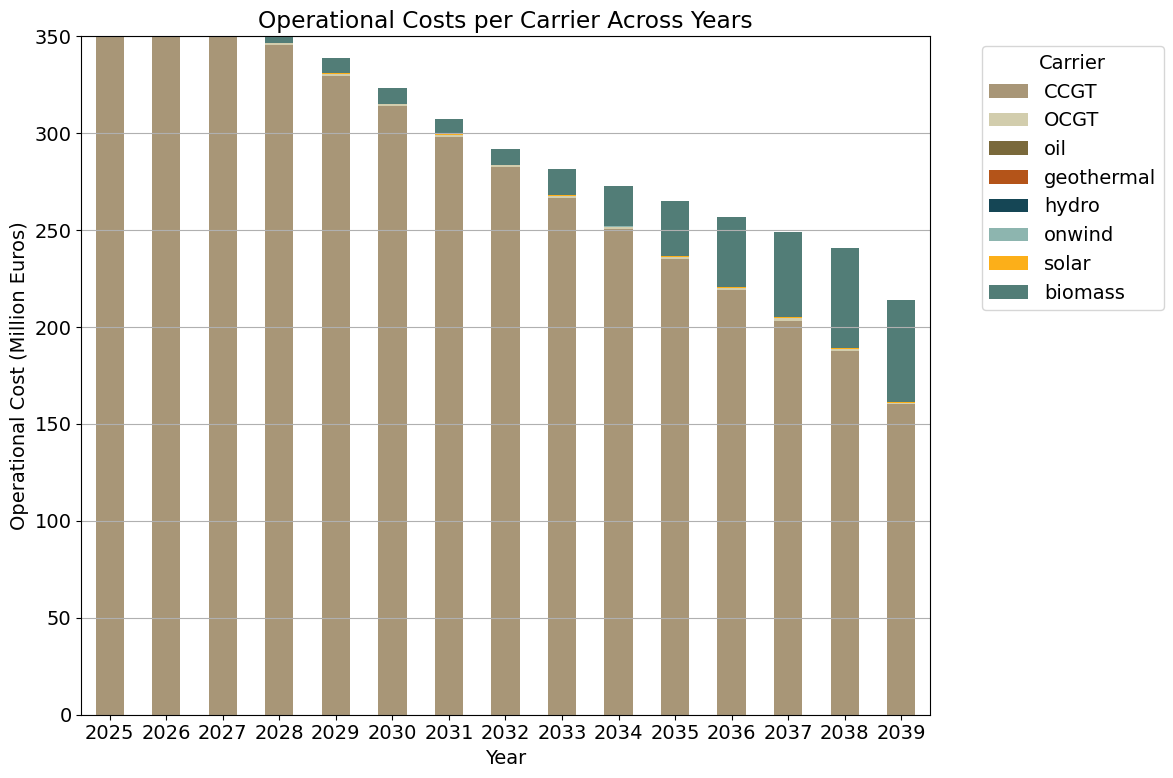

CCGT          4223.918888
OCGT            14.302145
oil              0.180660
geothermal       0.036698
hydro            0.000000
onwind           0.231219
solar            4.599421
biomass        310.423734
dtype: float64

In [1724]:
operational_costs_per_carrier = calculate_operational_costs_per_carrier(years)
operational_scalar = sum((1+discountrate)**(-j) for j in list(range(0,5)))
operational_costs_per_carrier.iloc[:, 1:] *= operational_scalar
operational_costs_per_carrier.set_index('year', inplace=True)
operational_costs_per_carrier.plot(kind='bar', stacked=True, figsize=(12, 8), color=[beige2,beige3,beige1,brown2,teal2,teal4,yellow,teal3])
plt.xlabel('Year')
plt.ylabel('Operational Cost (Million Euros)')
plt.title('Operational Costs per Carrier Across Years')
plt.legend(title='Carrier', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='y')
plt.xticks(rotation=0)
plt.tight_layout()
plt.ylim(0,350)
plt.show()
operational_costs_per_carrier.sum()

In [1725]:
if PyPSA_OG_validering:
    
    new_installed_cap = get_new_installed_hydro(years)
    new_installed_bat = get_new_installed_battery(years)
    new_installed_lines = get_new_installed_lines(years)
    capital_cost_lines = capcost_lines(2029)

    capital_costs_1 = []
    accumulated_new_cap = []
    capital_cost_by_type = []
    period = 1
    pv_capital_costs = []

    for y in years:

        network = networks[y]
        capex_value = 0
        total_capex = 0
        total_gen_capex = 0
        total_bat_capex = 0
        total_line_capex = 0

        if 2029 < y < 2035:
            period = 2
        elif y >= 2035:
            period = 3

        for carrier in new_installed_cap.columns:
            accumulated_new_cap = new_installed_cap.loc[: y, carrier].sum()
            capex_value += accumulated_new_cap *  capital_cost_df.loc[carrier, 'capital_cost']

        bat_capex = new_installed_bat.loc[:y, 'Battery Storage'].sum() * capital_cost_df.loc['battery storage', 'capital_cost']
        bat_capex += new_installed_bat.loc[:y, 'Charger'].sum() * capital_cost_df.loc['battery inverter', 'capital_cost']
        bat_capex += new_installed_bat.loc[:y, 'Discharger'].sum() * capital_cost_df.loc['battery inverter', 'capital_cost']
        for line in new_installed_lines.columns:
            line_capex = new_installed_lines.loc[:y, str(line)].sum() * capital_cost_lines.loc[line, 'capital_cost']
            capex_value += line_capex
            line_capex_empire += calculate_present_value(capex_value,y,first_year)

        sum_capex = capex_value + bat_capex

        for i in range(5):
            total_capex += calculate_present_value(sum_capex, 2025 + i + (5*(period-1)), 2025)
            total_gen_capex += calculate_present_value(capex_value, 2025 + i + (5*(period-1)), 2025)
            total_bat_capex += calculate_present_value(bat_capex, 2025 + i + (5*(period-1)), 2025)
            total_line_capex += calculate_present_value(line_capex, 2025 + i + (5*(period-1)), 2025)

        pv_capital_costs.append(total_capex/1e6)
        capital_cost_by_type.append({'Period': y, 'Type': 'Generators', 'Investment': total_gen_capex/1e6})
        capital_cost_by_type.append({'Period': y, 'Type': 'Storage', 'Investment': total_bat_capex/1e6})
        capital_cost_by_type.append({'Period': y, 'Type': 'Transmission Lines', 'Investment': total_line_capex/1e6})


    capital_cost_by_type_df = pd.DataFrame(capital_cost_by_type)

    operational_scalar = sum((1+discountrate)**(-j) for j in list(range(0,5)))
    opex = [networks[year].statistics.opex().sum()*operational_scalar / 1e6 for year in years]
    pv_opex = [calculate_present_value(i, year-4, first_year_empire, 0.04) for i, year in zip(opex, years)]

    print('Capital costs: ', sum(pv_capital_costs)/1e3)
    print('Opex: ', sum(pv_opex)/1e3)

In [1748]:
sum(capital_costs_1), sum(capital_costs_2), sum(capital_costs_3)

(3185.7965424820786, 2892.6124151748077, 3498.5121299248926)

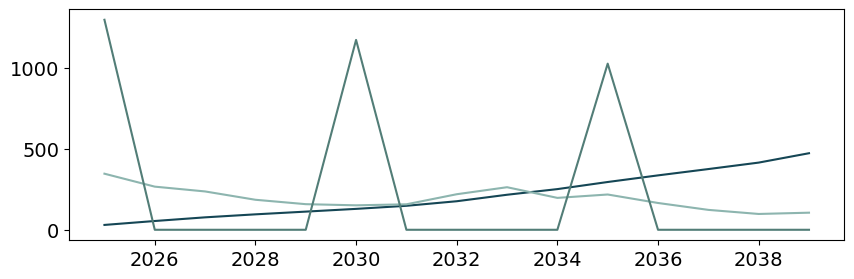

In [1749]:
plt.figure(figsize=(10, 3))
plt.plot(years, capital_costs_1, label='PyPSA OG', color=teal2)
plt.plot(years, capital_costs_2, label='PyPSA Compare', color=teal4)
plt.plot(years, capital_costs_3, label='Empire', color=teal3)
plt.show()

Capital costs:  2.9563719819966536
Opex:  0.7088381767490678
NPV:  3.7376755854452397


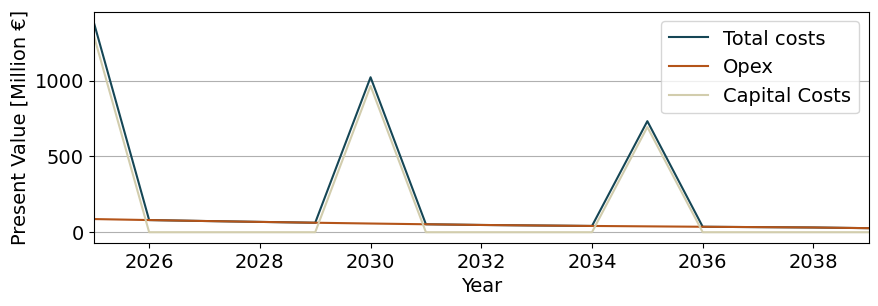

In [1728]:
total_pv = [pv_capital_costs[i] + pv_operational_costs[i] for i in range(len(years))]
total_pv_df = pd.DataFrame(total_pv)

print('Capital costs: ', sum(pv_capital_costs)/1e3)
print('Opex: ', sum(pv_opex)/1e3)
print('NPV: ',sum(total_pv)/1e3)

plt.figure(figsize=(10, 3))
plt.plot(years, total_pv, color=teal2, label='Total costs')
plt.plot(years, pv_operational_costs, color=brown2, label='Opex')
plt.plot(years, pv_capital_costs, color=beige3, label='Capital Costs')
#plt.xticks(years, [int(year) for year in years])
plt.xlabel('Year')
plt.ylabel('Present Value [Million €]')
plt.xlim(first_year,final_year)
#plt.ylim(0,400)
plt.grid(axis='y')
plt.legend()
plt.show()

<Figure size 1000x300 with 0 Axes>

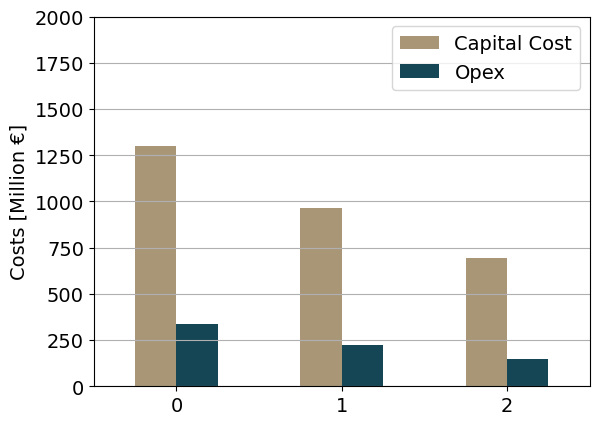

In [1729]:
# Plotting like in EMPIRE
if Empire or PyPSA_compare:
    empire_opex = []
    empire_cap_cost = []
    periods = 3
    for i in range(periods):
        empire_opex.append(sum(pv_opex[j] for j in range(i*5, i*5+5)))
        empire_cap_cost.append(sum(pv_capital_costs[j] for j in range(i*5, i*5+5)))

    empire_total_cost = [empire_opex[i] + empire_cap_cost[i] for i in range(periods)]

    cost_dataframe = pd.DataFrame({'Capital Cost': empire_cap_cost, 'Opex': empire_opex})

    periods = ['2025-2030', '2030-2035', '2035-2040']

    plt.figure(figsize=(10, 3))
    cost_dataframe.plot(kind='bar', color=[beige2,teal2], label='Total costs')
    plt.ylabel('Costs [Million €]', fontsize=14)
    plt.xticks(rotation = 0, fontsize=14)
    plt.ylim(0,2000)
    plt.grid(axis='y')
    plt.show()

Period                                                    18306
Type          GeneratorsStorageTransmission LinesGeneratorsS...
Investment                                           2527.11916
dtype: object


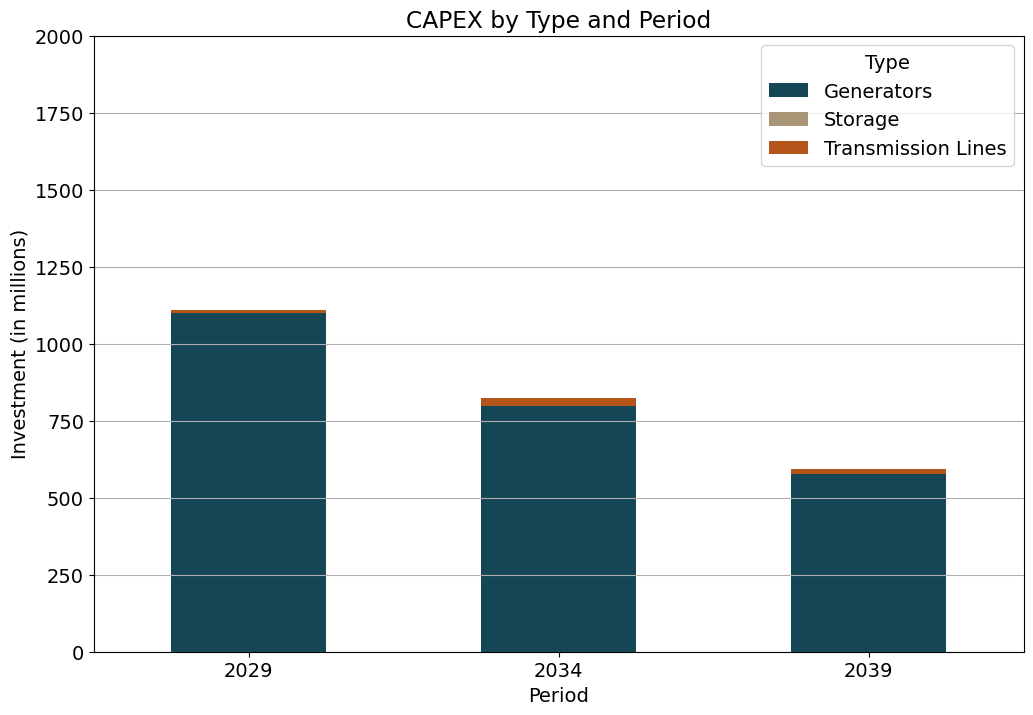

Type     Generators   Storage  Transmission Lines
Period                                           
2029    1099.323105  0.034327           10.212434
2034     797.955149  0.025429           26.577018
2039     577.801678  0.118589           15.071431


In [1730]:
fig, ax = plt.subplots()
capital_cost_by_type_df.pivot(index='Period', columns='Type', values='Investment').plot(kind='bar', stacked=True, figsize=(12, 8), ax=ax, color=[teal2, beige2, brown2])
print(capital_cost_by_type_df.sum())
ax.set_ylabel('Investment (in millions)')
ax.set_title('CAPEX by Type and Period')
plt.xticks(rotation = 0)
plt.ylim(0,2000)
plt.grid(axis='y')
plt.show()
print(capital_cost_by_type_df.pivot(index='Period', columns='Type', values='Investment'))

Period                                                    18306
Type          GeneratorsStorageTransmission LinesGeneratorsS...
Investment                                          3164.975688
dtype: object


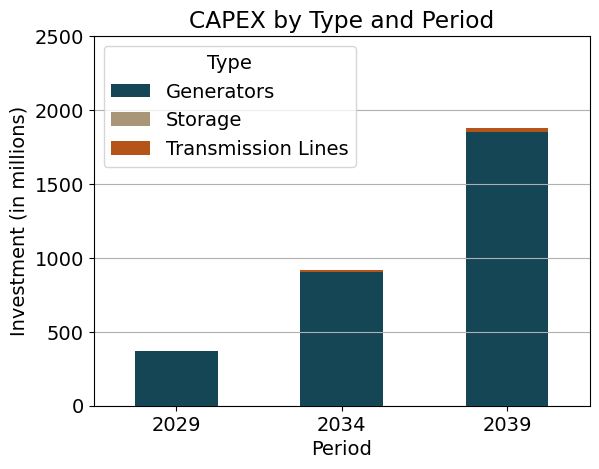

In [1731]:
if PyPSA_OG:
    fig, ax = plt.subplots()
    capital_cost_by_type_empire_df.pivot(index='Period', columns='Type', values='Investment').plot(kind='bar', stacked=True, ax=ax, color=[teal2, beige2, brown2])
    print(capital_cost_by_type_empire_df.sum())
    ax.set_ylabel('Investment (in millions)')
    ax.set_title('CAPEX by Type and Period')
    plt.xticks(rotation = 0)
    plt.ylim(0,2500)
    plt.grid(axis='y')
    plt.show()

In [1732]:
if save_to_csv:
    total_pv_df = pd.DataFrame(total_pv)
    try:
        df = pd.read_csv(path + 'result_data/total_costs.csv')
    except FileNotFoundError:
        df = pd.DataFrame()
    df[case_path] = total_pv_df.iloc[:]
    df.to_csv(path + 'result_data/total_costs.csv', index=False)

if all_saved:
    df = pd.read_csv(path + 'result_data/total_costs.csv')

    plt.figure(figsize=(10, 6)) 

    num_scenarios = len(df.columns)
    labels = ['Base', 'Base NZE', 'Sudden', 'Sudden NZE', 'Gradual', 'Gradual NZE']
    df.columns = labels
    colors = [brown2, teal4, beige2, teal3, beige3, teal2]

    for i, column in enumerate(df.columns):
        # Calculate the positions for the current column
        positions = range(i, len(df) * len(df.columns), len(df.columns))
        plt.bar(positions, df[column], width=0.8, label=column, color=colors[i])

    # Set the title and labels
    plt.title('Total Costs for Different Scenarios')
    plt.ylabel('Total Costs [billion €]')

    # Set x-ticks to be in the middle of the group of bars for each scenario
    tick_positions = range(len(df.columns) // 2, len(df) * len(df.columns), len(df.columns))
    plt.xticks(range(num_scenarios), df.columns)

    #plt.legend()
    plt.grid(axis='y')
    plt.ylim(0,8)
    #plt.savefig(path_fig + 'total_cost.png', dpi=300, bbox_inches='tight')
    plt.show()
    
# else:
#     annual_costs_series.plot(kind='bar', figsize=(4, 4), color=teal2)
#     plt.ylabel('Total cost [billion €]')
#     #plt.ylim(0,18)
#     plt.xlabel('Base')
#     plt.grid(axis='y')
#     plt.savefig(path_fig + 'total_cost.png', dpi=300, bbox_inches='tight')

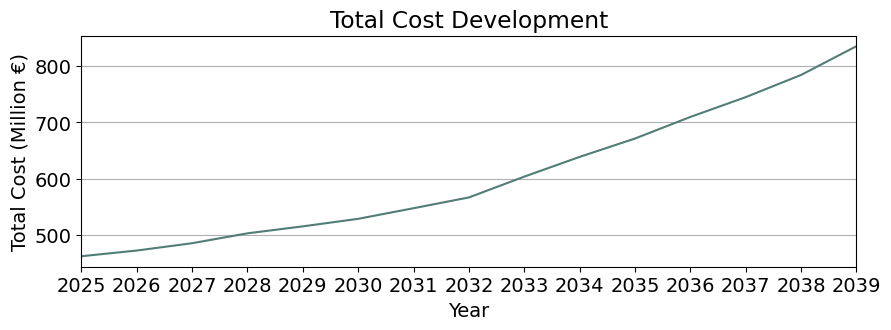

In [1733]:
total_costs = [get_total_cost(year).sum() for year in years]
plt.figure(figsize=(10, 3))
plt.plot(years, total_costs, color=teal3)
plt.xticks(years, [int(year) for year in years])
plt.title('Total Cost Development')
plt.xlabel('Year')
plt.ylabel('Total Cost (Million €)')
plt.xlim(first_year,final_year)
#plt.ylim(0,1200)
plt.grid(axis='y')
plt.show()

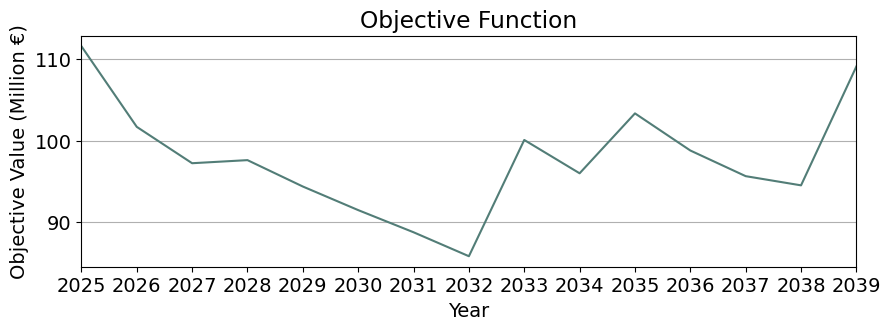

In [1734]:
total_objective = [get_objective(year).sum() for year in years]
plt.figure(figsize=(10, 3))
plt.plot(years, total_objective, color=teal3)
plt.xticks(years, [int(year) for year in years])
plt.title('Objective Function')
plt.xlabel('Year')
plt.ylabel('Objective Value (Million €)')
plt.xlim(first_year,final_year)
#plt.ylim(0,400)
plt.grid(axis='y')
plt.show()

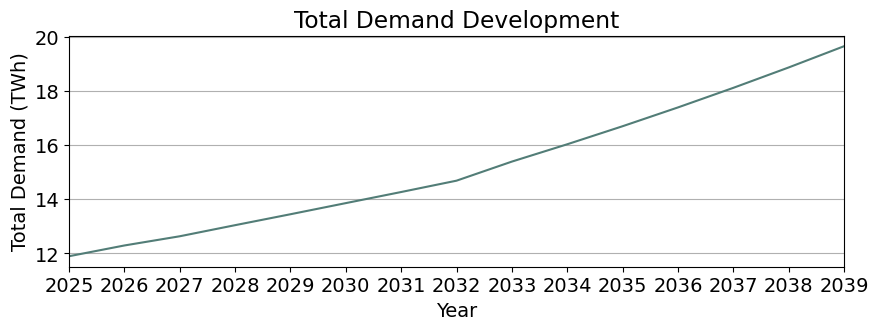

In [1735]:
total_demand = [get_demand(year) for year in years]
plt.figure(figsize=(10, 3))
plt.plot(years, total_demand, color=teal3)
plt.xticks(years, [int(year) for year in years])
plt.title('Total Demand Development')
plt.xlabel('Year')
plt.ylabel('Total Demand (TWh)')
plt.xlim(first_year,final_year)
plt.grid(axis='y')
plt.show()

[]

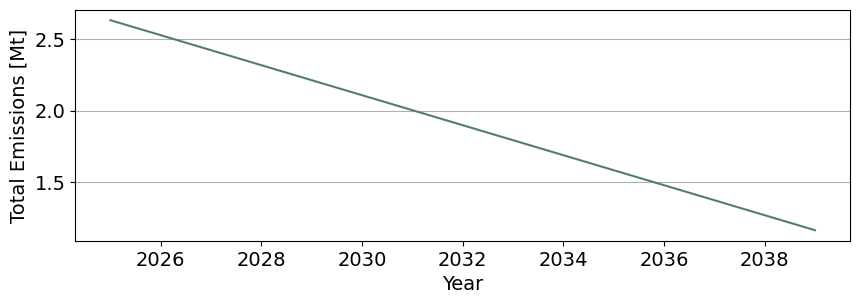

In [1736]:
total_emissions = [get_emissions(year) for year in years]
if save_to_csv:
    total_emissions_df = pd.DataFrame({'Year': years, 'Emissions': total_emissions})

    try:
        # Try to read the existing file
        df = pd.read_csv(path + 'result_data/emissions.csv')
    except FileNotFoundError:
        # If file does not exist, create a new DataFrame
        df = pd.DataFrame()
  


    if case_path not in df.columns:
        df[case_path] = total_emissions_df['Emissions']
    df.to_csv(path + 'result_data/emissions.csv', index=False)


# if all_saved:
#     df = pd.read_csv(path + 'result_data/emissions.csv')
#     df = df.set_index('Year')

#     labels = ['Base', 'Base Cap', 'Sudden', 'Sudden Cap', 'Gradual']
#     df.columns = labels
#     colors = [beige2, beige3, teal4, teal3, teal2]

#     plt.figure(figsize=(10, 6))  # Adjust the size as needed
#     for column in df.columns:
#         df[column].plot(label=column, color=colors[df.columns.get_loc(column)])
#     plt.title('Emissions Over Years for Different Scenarios')
#     plt.xlabel('Year')
#     plt.ylabel('Emissions')
#     plt.legend()
#     plt.grid(axis='y')
#     plt.ylim(0,7)
#     #plt.savefig(path_fig + 'emissions.png', dpi=300, bbox_inches='tight')
#     plt.show()

# else:
#     plt.figure(figsize=(10, 3))
#     plt.plot(years, total_emissions, color=teal3)
#     plt.xticks(years, [int(year) for year in years])
#     plt.title(case + ' - Total Emissions Development')
#     plt.xlabel('Year')
#     plt.ylabel('Total Emissions (Mt)')
#     plt.xlim(first_year,final_year)
#     plt.ylim(0,3)
#     plt.grid(axis='y')
    #plt.savefig(path_fig + 'emissions.png', dpi=300, bbox_inches='tight')

plt.figure(figsize=(10, 3))
plt.plot(years, total_emissions, color=teal3)
plt.ylabel('Total Emissions [Mt]')
plt.xlabel('Year')
plt.grid(axis='y')
plt.plot()

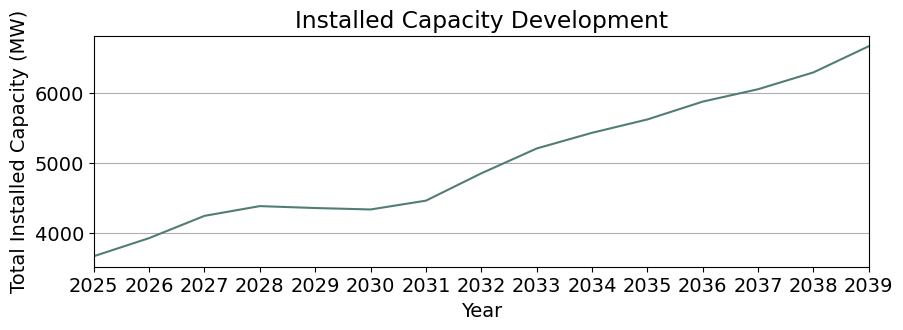

In [1737]:
total_capacity = [get_installed_capacity(year).sum().sum() for year in years]
plt.figure(figsize=(10, 3))
plt.plot(years, total_capacity, color=teal3)
plt.xticks(years, [int(year) for year in years])
plt.title('Installed Capacity Development')
plt.xlabel('Year')
plt.ylabel('Total Installed Capacity (MW)')
plt.xlim(first_year,final_year)
#plt.ylim(0,6000)
plt.grid(axis='y')
plt.show()

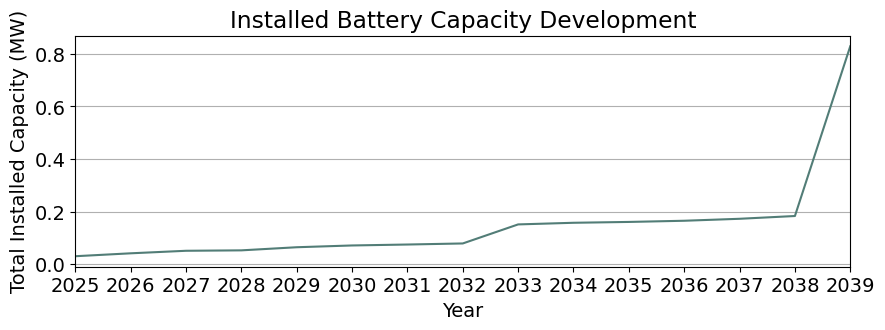

In [1738]:
total_bat_capacity = [get_installed_capacity_battery(year).sum().sum() for year in years]
plt.figure(figsize=(10, 3))
plt.plot(years, total_bat_capacity, color=teal3)
plt.xticks(years, [int(year) for year in years])
plt.title('Installed Battery Capacity Development')
plt.xlabel('Year')
plt.ylabel('Total Installed Capacity (MW)')
plt.xlim(first_year,final_year)
#plt.ylim(0,6000)
plt.grid(axis='y')
plt.show()

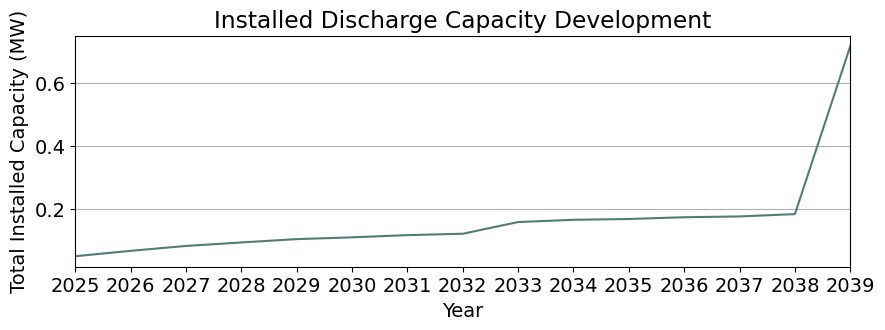

In [1739]:
total_discharge_capacity = [get_installed_capacity_charge(year).sum().sum() for year in years]
plt.figure(figsize=(10, 3))
plt.plot(years, total_discharge_capacity, color=teal3)
plt.xticks(years, [int(year) for year in years])
plt.title('Installed Discharge Capacity Development')
plt.xlabel('Year')
plt.ylabel('Total Installed Capacity (MW)')
plt.xlim(first_year,final_year)
#plt.ylim(0,6000)
plt.grid(axis='y')
plt.show()

CCGT 29275.127042852953
OCGT 180.12382616318826
Oil 0.013686102675050393
Geothermal 8997.327432897344
Hydro 70080.90968251647
Wind 101.88424789971954
Solar 52351.443067577864
Biomass 59507.54086486665
LL -0.06719423271965752
Demand -220494.1489586864


Text(0.5, 1.0, 'Base NZE 30 - 2037')

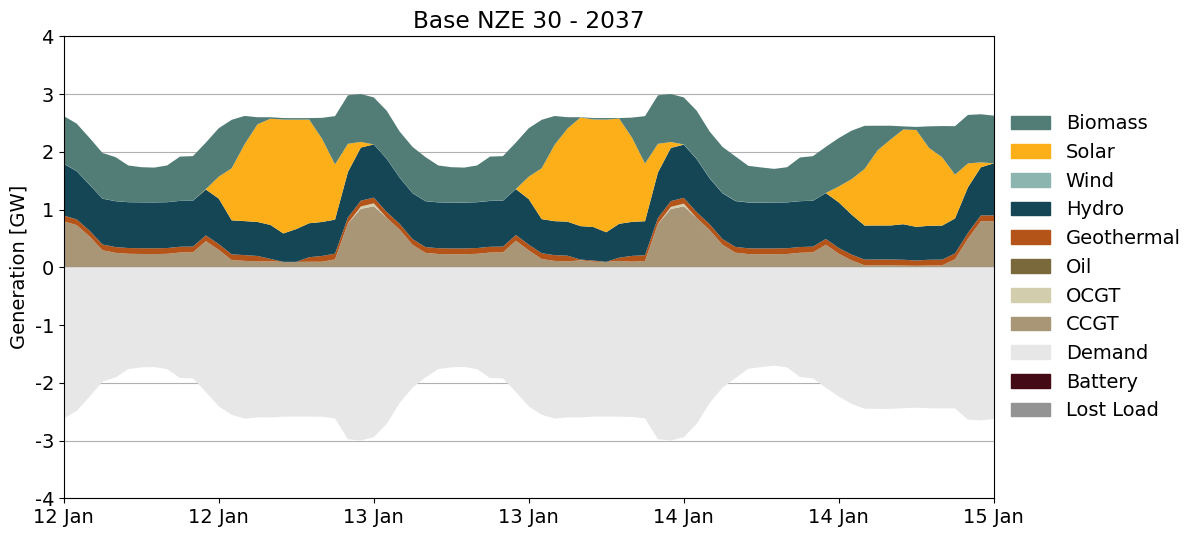

In [1740]:
first_date = "2013-01-12"
second_date = "2013-01-15"
year = final_year

CCGT = get_snapshot_generation(year, first_date, second_date, 'CCGT')
OCGT = get_snapshot_generation(year, first_date, second_date, 'OCGT')
Oil = get_snapshot_generation(year, first_date, second_date, 'oil')
Geothermal = get_snapshot_generation(year, first_date, second_date, 'geothermal')
Hydro = get_snapshot_generation(year, first_date, second_date, 'ror')
Hydro += get_snapshot_generation(year, first_date, second_date, 'hydro')
Wind = get_snapshot_generation(year, first_date, second_date, 'onwind')
Solar = get_snapshot_generation(year, first_date, second_date, 'solar')
Biomass = get_snapshot_generation(year, first_date, second_date, 'biomass')
Battery = get_snapshot_generation(year, first_date, second_date, 'battery')
#H2 = get_snapshot_generation(year, first_date, second_date, 'H2')
demand = get_snapshot_demand(year, first_date, second_date)   

i=0
nbattery = []
pbattery =[]
for i in Battery:
    if i < 0:
        nbattery.append(i)
    else:
        nbattery.append(0) 
for i in Battery:
    if i > 0:
        pbattery.append(i)
    else:
        pbattery.append(0) 
nbattery_9 = [float(n) / 0.9 for n in nbattery]
pbattery_9 = [float(n) * 0.9 for n in pbattery]
LL = (demand.values + nbattery_9)*-1 - (CCGT + OCGT +Oil +Wind +Solar +Biomass +Hydro +pbattery_9 + Geothermal)

snapshots = {'CCGT': CCGT, 'OCGT': OCGT, 'Oil': Oil,'Geothermal': Geothermal, 'Hydro': Hydro, 'Wind': Wind, 'Solar': Solar, 'Biomass': Biomass, 'Battery': pbattery, 'Nbattery': nbattery, 'Lost load': LL,'Demand': demand}
df_snapshots = pd.DataFrame(snapshots)
if save_to_csv:
    df_snapshots.to_csv(path + 'result_data/' + case_path + '_snapshots.csv')

print('CCGT',CCGT.sum())
print('OCGT',OCGT.sum())
print('Oil',Oil.sum())
print('Geothermal',Geothermal.sum())
print('Hydro',Hydro.sum())
print('Wind',Wind.sum())
print('Solar',Solar.sum())
print('Biomass',Biomass.sum())
print('LL',LL.sum())
print('Demand', demand.sum())

#print('CCGT: ', CCGT.sum())
# print('OCGT: ', OCGT.sum())
# print('Wind: ', Wind.sum())
# print('Solar: ', Solar.sum())
# print('Hydro: ', Hydro.sum())
# print('Oil: ', Oil.sum())
# print('Geothermal ',Geothermal.sum())
# print('Biomass: ', Biomass.sum())
# print('Battery: ', Battery.sum())
#print('H2: ', H2.sum())

fig, ax=plt.subplots(figsize = (12,6))
A = plt.stackplot(CCGT.index,CCGT,OCGT,Oil, Geothermal, Hydro, Wind, Solar, Biomass, pbattery, LL,
                  colors=[beige2,beige3,beige1,brown2, teal2, teal4,yellow,teal3, brown, grey4], zorder = 2) #,   purple3
plt.stackplot(CCGT.index,demand,nbattery, colors=[grey1, brown], zorder = 2) #,nbattery
plt.xticks(rotation = 0)
plt.yticks()
scale_y = 1e3
ticks_y = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_y))
ax.yaxis.set_major_formatter(ticks_y)
myFmt = mdates.DateFormatter('%d %b')
ax.xaxis.set_major_formatter(myFmt)
ax.set_ylabel('Generation [GW]')

start_date = pd.to_datetime(first_date)
end_date = pd.to_datetime(second_date)

ax.set_xlim(start_date, end_date)
ax.set_ylim(-4000, 4000)


biomass_patch = mpatches.Patch(color = teal3, label = 'Biomass')
solar_patch = mpatches.Patch(color=yellow, label ='Solar')
wind_patch = mpatches.Patch(color=teal4, label ='Wind')
hydro_patch = mpatches.Patch(color = teal2, label = 'Hydro')
geo_patch = mpatches.Patch(color = brown2, label = 'Geothermal')
oil_patch = mpatches.Patch(color=beige1, label = 'Oil')
OCGT_patch = mpatches.Patch(color=beige3, label ='OCGT')
CCGT_patch = mpatches.Patch(color=beige2, label ='CCGT')
load_patch = mpatches.Patch(color=grey1, label ='Demand')
battery_patch = mpatches.Patch(color=brown, label ='Battery')
LL_patch = mpatches.Patch(color=grey4, label ='Lost Load')
#H2_patch = mpatches.Patch(color=red2, label ='H2')
handles=[biomass_patch, solar_patch, wind_patch, hydro_patch, geo_patch,oil_patch, OCGT_patch, CCGT_patch, load_patch, battery_patch, LL_patch]
ax.legend(handles=handles, frameon = False, loc='center left', bbox_to_anchor=(1, 0.5))
ax.grid(axis='y', zorder=0)
plt.title(case + ' - 2037')
#plt.savefig(path_fig + 'snapshot.png', dpi=300, bbox_inches='tight')

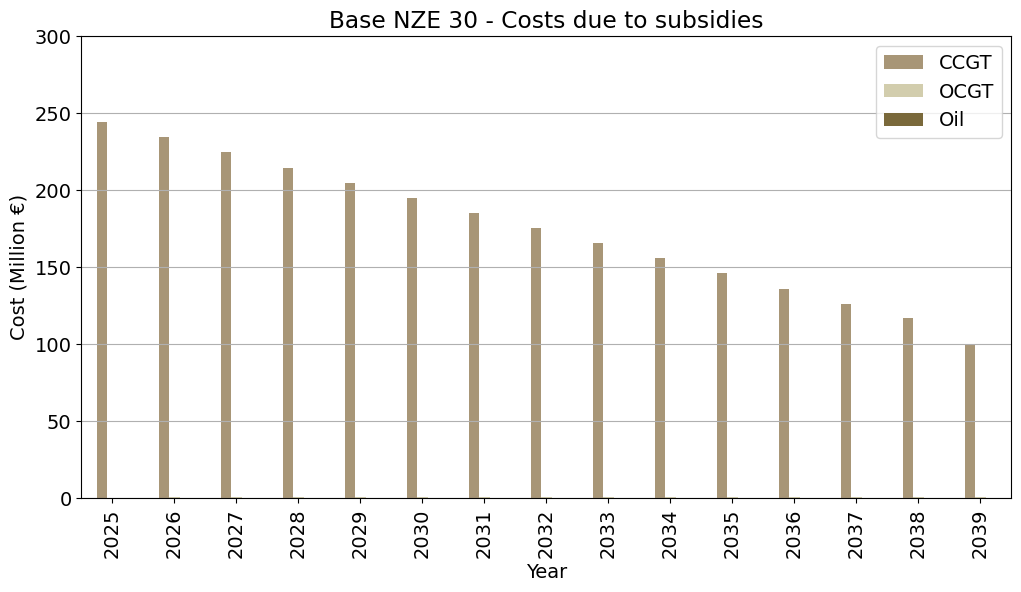

In [1741]:
subsidies = get_subsidies()
cost_of_subsidies = {}

for year in years:
    for (subsidy_year, carrier), subsidy_rate in subsidies.items():
        if carrier == 'oil':
            carrier = 'Oil'
        # Check if we're looking at the correct year for the subsidy
        if subsidy_year == year:
            # Initialize a dictionary for this year if not already present
            if year not in cost_of_subsidies:
                cost_of_subsidies[year] = {}

            cost_of_subsidies[year][carrier] = 0

            # Check if the carrier is present in the production DataFrame
            if carrier in production.columns:
                # Calculate and store the cost of subsidies for this carrier in this year
                cost_of_subsidies[year][carrier] = subsidy_rate * production.loc[year,carrier]

cost_of_subsidies_df = pd.DataFrame()
for year, carriers in cost_of_subsidies.items():
    for carrier, cost in carriers.items():
        cost_of_subsidies_df.loc[year, carrier] = cost
cost_of_subsidies_df = rename_columns(cost_of_subsidies_df)
cost_of_subsidies_df.plot(kind='bar', figsize=(12, 6), color=get_colors(cost_of_subsidies_df.columns))
plt.title(case + ' - Costs due to subsidies')
plt.ylabel('Cost (Million €)')
plt.xlabel('Year')
plt.ylim(0,300)
plt.grid(axis='y')
#plt.savefig(path_fig + 'subsidies.png', dpi=300, bbox_inches='tight')

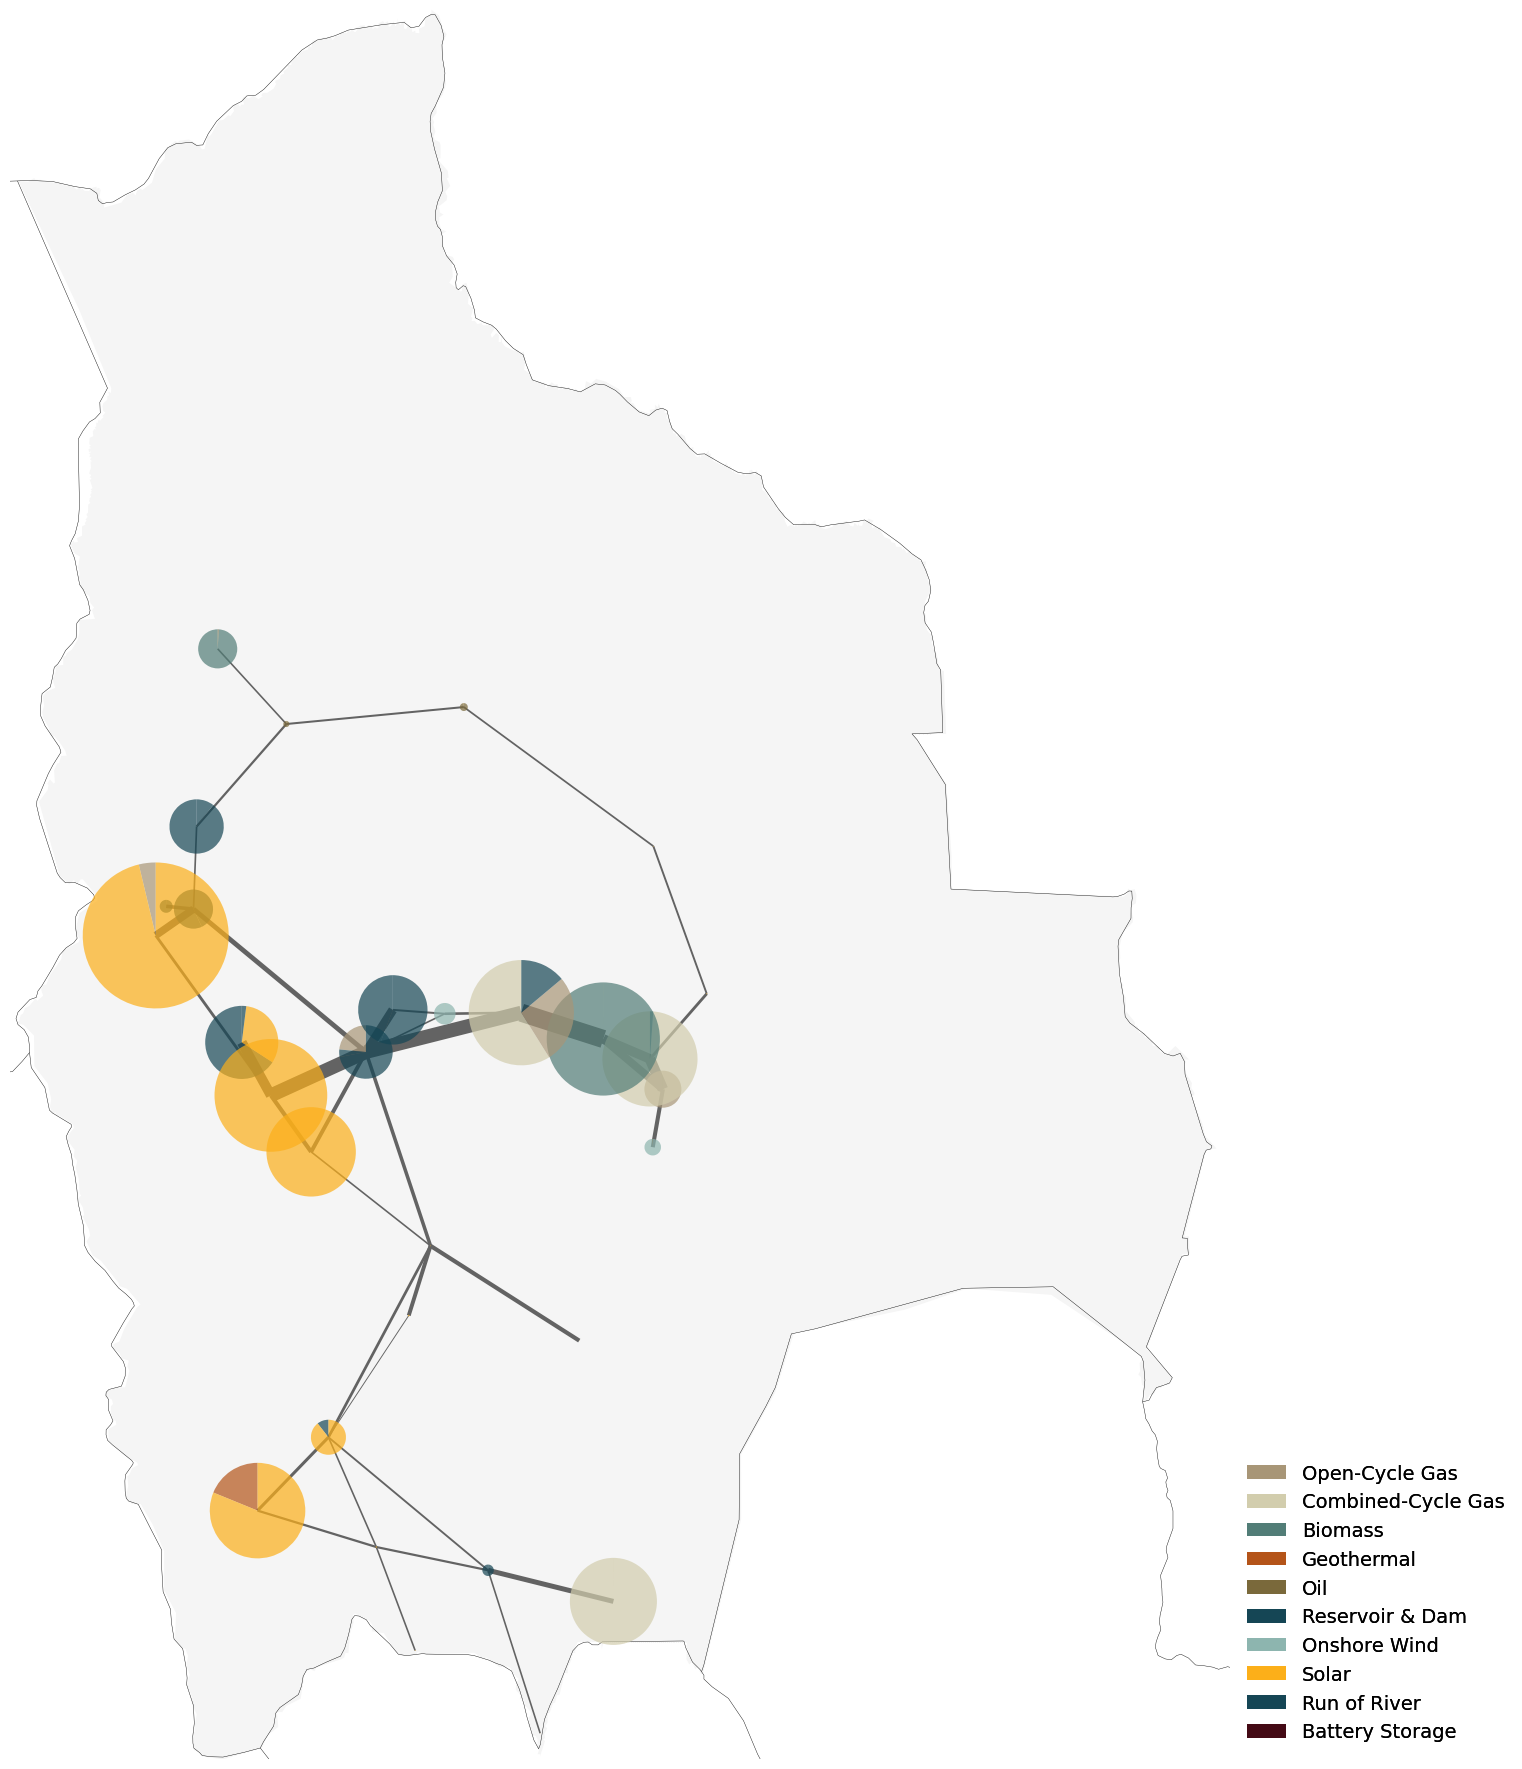

In [1742]:
network_fin = networks[final_year]
n = network_fin
 
if 'PHS' in n.carriers.index:
    n.carriers = n.carriers.drop(index='PHS')
if 'Load' in n.carriers.index:
    n.carriers = n.carriers.drop(index='Load')
n.carriers.color = [beige3, beige2, teal3, brown2, beige1, teal2, teal4, yellow, teal2, brown]
n.carriers.color['geothermal'] = brown2
n.carriers.color['ror'] = teal2
n.carriers.color['hydro'] = teal2
n.carriers.color['battery'] = brown
n.carriers.color['CCGT'] = beige3
n.carriers.color['OCGT'] = beige2
n.carriers.color['oil'] = beige1
n.carriers.color['onwind'] = teal4
n.carriers.color['solar'] = yellow
n.carriers.color['biomass'] = teal3
n.carriers
 
 
bus_scale = 3e3
line_scale = 1e2
 
from pypsa.plot import add_legend_circles, add_legend_lines, add_legend_patches
 
regions_onshore = gpd.read_file(path + "resources/shapes/country_shapes.geojson")
 
fig, ax = plt.subplots(figsize=(15, 20), subplot_kw={"projection": ccrs.EqualEarth(n.buses.x.mean())})
gen = n.generators
gen = gen[~gen['carrier'].str.contains('load')]
gen = gen.groupby(["bus", "carrier"]).p_nom_opt.sum()
sto = n.storage_units.groupby(["bus", "carrier"]).p_nom_opt.sum()
buses = pd.concat([gen, sto])
 
bus_sizes = buses / bus_scale
 
line_snom = n.lines.s_nom
 
with plt.rc_context({"patch.linewidth": 0.}):
    n.plot(
        bus_sizes=buses / bus_scale,
        bus_alpha=0.7,
        line_widths=n.lines.s_nom_opt / line_scale,
        link_widths=n.links.p_nom_opt / line_scale,
        line_colors='#636363',
        ax=ax,
        margin=0.2,
        color_geomap=None,
    )
regions_onshore.plot(
    ax=ax,
    facecolor="whitesmoke",
    edgecolor="white",
    aspect="equal",
    transform=ccrs.PlateCarree(),
    linewidth=0,
)
ax.set_extent(regions_onshore.total_bounds[[0, 2, 1, 3]])
legend_kwargs = {"loc": "upper left", "frameon": False}
# circles legend may requite some fine-tuning
legend_circles_dict = {"bbox_to_anchor": (1, 0.6), "labelspacing": 5, **legend_kwargs}
bus_sizes = [50, 500, 1000, 1500, 2000]  # in MW
line_sizes = [100, 500, 1000, 1500]  # in MW
 
# add_legend_circles(
#     ax,
#     [s / bus_scale for s in bus_sizes],
#     [f"{s/1000} GW" for s in bus_sizes],
#     patch_kw={"alpha": 0.8},
#     legend_kw=legend_circles_dict,    
# )
# add_legend_lines(
#     ax,
#     [s / line_scale for s in line_sizes],
#     [f"{s} MW" for s in line_sizes],
#     legend_kw={"bbox_to_anchor": (1, 0.8), **legend_kwargs},
# )
add_legend_patches(
    ax,
    n.carriers.color,
    n.carriers.nice_name,
    legend_kw={"bbox_to_anchor": (1, 0), **legend_kwargs, "loc":"lower left"},
)
 
#plt.title(f"{case} - {final_year}")
 
fig.tight_layout()
 

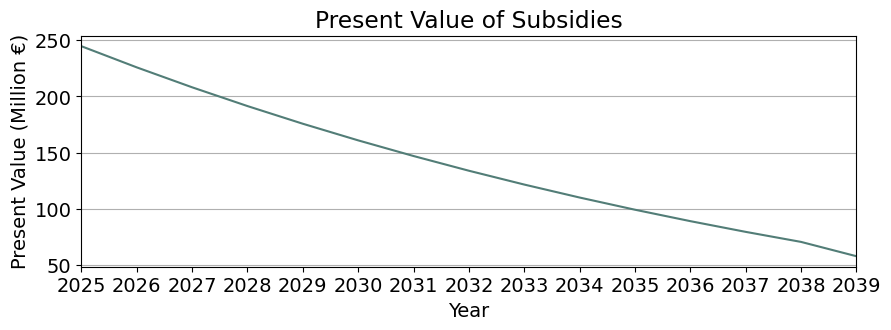

In [1743]:
yearly_subsidies = cost_of_subsidies_df.sum(axis=1)
pv_subsidies = [calculate_present_value(yearly_subsidies.loc[years[i]], years[i], first_year, 0.04) for i in range(len(years))]
npv_subsidies = sum(pv_subsidies)

plt.figure(figsize=(10, 3))
plt.plot(years, pv_subsidies, color=teal3)
plt.xticks(years, [int(year) for year in years])
plt.title('Present Value of Subsidies')
plt.xlabel('Year')
plt.ylabel('Present Value (Million €)')
plt.xlim(first_year,final_year)
#plt.ylim(0,300)
plt.grid(axis='y')
plt.show()


In [1744]:
if save_to_csv:
    try:
        # Try to read the existing file
        df = pd.read_csv(path + 'result_data/subsidies.csv')
    except FileNotFoundError:
        # If file does not exist, create a new DataFrame
        df = pd.DataFrame()

    # Add the new data as a column
    df[case_path] = [npv_subsidies]

    # Write the updated DataFrame to the file
    df.to_csv(path + 'result_data/subsidies.csv', index=False)

# if all_saved:
#     df = pd.read_csv(path + 'result_data/subsidies.csv')

#     plt.figure(figsize=(10, 6)) 

#     num_scenarios = len(df.columns)
#     labels = ['Base', 'Base Cap', 'Sudden', 'Sudden Cap', 'Gradual', 'Gradual Cap']
#     df.columns = labels
#     colors = [beige2, beige3, teal4, teal3, teal2]

#     for i, column in enumerate(df.columns):
#         # Calculate the positions for the current column
#         positions = range(i, len(df) * len(df.columns), len(df.columns))
#         plt.bar(positions, df[column], width=0.8, label=column, color=colors[i])

#     # Set the title and labels
#     plt.title('Total subsidies for Different Scenarios')
#     plt.ylabel('Total Subsidies [billion €]')

#     # Set x-ticks to be in the middle of the group of bars for each scenario
#     tick_positions = range(len(df.columns) // 2, len(df) * len(df.columns), len(df.columns))
#     plt.xticks(range(num_scenarios), df.columns)

#     #plt.legend()
#     plt.grid(axis='y')
#     plt.ylim(0,8)
#     plt.savefig(path_fig + 'subsidies.png', dpi=300, bbox_inches='tight')
#     plt.show()

# else:
#     total_subsidies_series = pd.Series(total_subsidies)
#     total_subsidies_series.plot(kind='bar', figsize=(4, 4), color=teal2)
#     plt.ylabel('Total subsidies [billion €]')
#     #plt.ylim(0,18)
#     plt.xlabel(case_path)
#     plt.grid(axis='y')
#     plt.savefig(path_fig + 'subsidies.png', dpi=300, bbox_inches='tight')

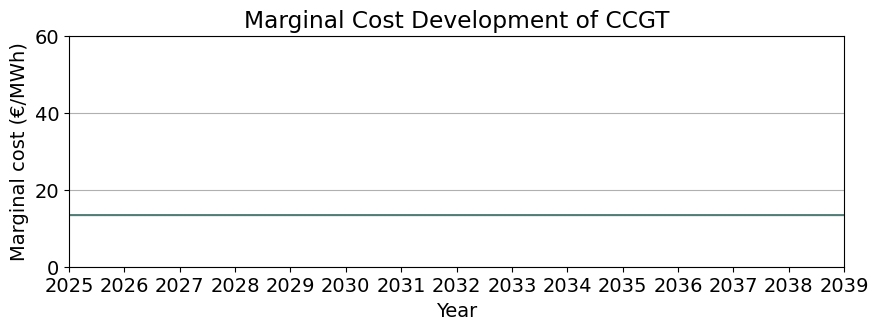

In [1745]:
marginal_cost_CCGT = [get_marginal_cost(year,'CCGT') for year in years]
plt.figure(figsize=(10, 3))
plt.plot(years, marginal_cost_CCGT, color=teal3)
plt.xticks(years, [int(year) for year in years])
plt.title('Marginal Cost Development of CCGT')
plt.xlabel('Year')
plt.ylabel('Marginal cost (€/MWh)')
plt.xlim(first_year,final_year)
plt.ylim(0,60)
plt.grid(axis='y')
plt.show()

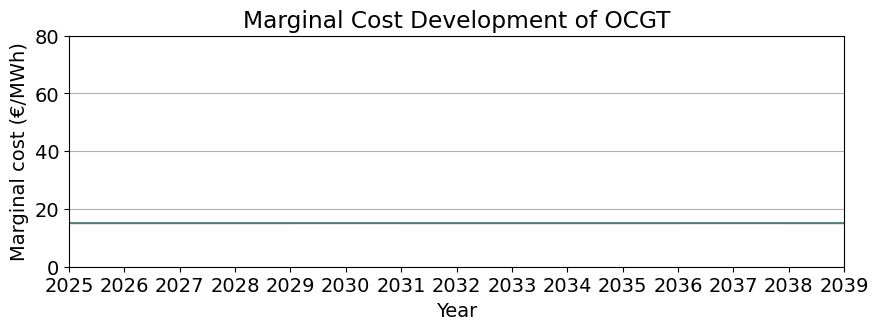

In [1746]:
marginal_cost_OCGT = [get_marginal_cost(year,'OCGT') for year in years]
plt.figure(figsize=(10, 3))
plt.plot(years, marginal_cost_OCGT, color=teal3)
plt.xticks(years, [int(year) for year in years])
plt.title('Marginal Cost Development of OCGT')
plt.xlabel('Year')
plt.ylabel('Marginal cost (€/MWh)')
plt.xlim(first_year,final_year)
plt.ylim(0,80)
plt.grid(axis='y')
plt.show()

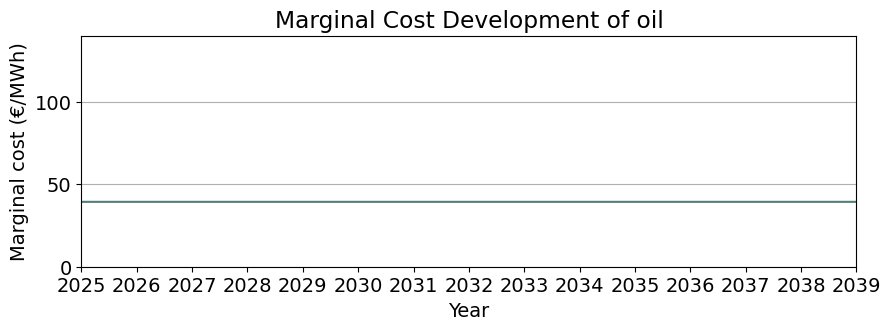

In [1747]:
marginal_cost_oil = [get_marginal_cost(year,'oil') for year in years]
plt.figure(figsize=(10, 3))
plt.plot(years, marginal_cost_oil, color=teal3)
plt.xticks(years, [int(year) for year in years])
plt.title('Marginal Cost Development of oil')
plt.xlabel('Year')
plt.ylabel('Marginal cost (€/MWh)')
plt.xlim(first_year,final_year)
plt.ylim(0,140)
plt.grid(axis='y')
plt.show()